In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import itertools
from matplotlib.pylab import rcParams

from statsmodels.graphics.tsaplots import plot_pacf, plot_acf
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import adfuller
import statsmodels.api as sm

from sklearn.metrics import mean_squared_error

import warnings
warnings.filterwarnings('ignore')

In [2]:
# def get_datetimes(df):
#     return pd.to_datetime(df.columns.values[1:], format='%Y-%m')

In [3]:
# font = {'family' : 'normal',
#         'weight' : 'bold',
#         'size'   : 22}

# matplotlib.rc('font', **font)
# NOTE: if you visualizations are too cluttered to read, try calling 'plt.gcf().autofmt_xdate()'!

In [4]:
# def melt_data(df, id_vars):
#     melted = pd.melt(df, id_vars=id_vars, var_name='time')
#     melted['time'] = pd.to_datetime(melted['time'], infer_datetime_format=True)
#     melted = melted.dropna(subset=['value'])
#     return melted.groupby('time').aggregate({'value':'mean'})

In [5]:
pp_dfs = []

def preprocess_data(df, id_vars, value_name):
    '''
    Prepare and split data for time series analysis.
    
    The data from https://www.zillow.com/research/data/ is in wide format.
    This function then puts the data in long format so time series analysis can be performed.
    Then it creates a new dataframe with only the relevant data, and puts it into a list.
    ---
    Input:
    
    df: a dataframe from csv from https://www.zillow.com/research/data/
    id_vars: all column names except the columns to be melted.
    value_name: name of the new long-format value.
    ---
    Output:
    
    The resulting dataframe.
    '''
    # wide to long format
    data = pd.melt(df, id_vars=id_vars, var_name='time', value_name=value_name)
    # only keep national and FL data
    us_data = data[data['RegionName'] == 'United States']
    fl_data = data[data['StateName'] == 'FL']
    # create new dataframe
    cc_data = pd.concat([us_data, fl_data])
    cc_data['time'] = pd.to_datetime(cc_data['time'], infer_datetime_format=True)
    cc_data = cc_data.reset_index(drop=True)
    # add to list of pre-processed dataframes
    pp_dfs.append(cc_data)

In [6]:
source_names = ['raw_data/Metro_invt_fs_all home_month.csv',
              'raw_data/Metro_med_doz_pending_all_home_month.csv',
              'raw_data/Metro_median_days_to_close_all_home_month.csv',
              'raw_data/Metro_median_sale_price_all_home_month.csv',
              'raw_data/Metro_median_sale_to_list_all_home_month.csv',
              'raw_data/Metro_new_listings_all_home_month.csv']

value_names = ['forsale_inv',
               'median_days_pending',
               'median_days_to_close',
               'median_sale_price',
               'median_sale_to_list_ratio',
               'new_listings']

id_vars = ['RegionID', 'SizeRank', 'RegionName', 'RegionType', 'StateName']

In [7]:
data_list = [pd.read_csv(file) for file in source_names]

In [8]:
for i in range(len(value_names)):
    preprocess_data(df=data_list[i], id_vars=id_vars, value_name=value_names[i])

In [9]:
# median_sale_price data
med_sp = pp_dfs[3]
med_sp

RegionID  SizeRank        RegionName RegionType StateName       time  \
0       102001         0     United States    country       NaN 2008-02-29   
1       102001         0     United States    country       NaN 2008-03-31   
2       102001         0     United States    country       NaN 2008-04-30   
3       102001         0     United States    country       NaN 2008-05-31   
4       102001         0     United States    country       NaN 2008-06-30   
...        ...       ...               ...        ...       ...        ...   
4649    395153       308  The Villages, FL        msa        FL 2022-12-31   
4650    395080       368       Sebring, FL        msa        FL 2022-12-31   
4651    394955       463       Palatka, FL        msa        FL 2022-12-31   
4652    394744       467      Key West, FL        msa        FL 2022-12-31   
4653    394476       669     Clewiston, FL        msa        FL 2022-12-31   

      median_sale_price  
0              180000.0  
1              185000.0  
2              185000.0  
3              187000.0  
4              193000.0  
...                 ...  
4649           398000.0  
4650           220000.0  
4651           225000.0  
4652           800000.0  
4653           200000.0  

[4654 rows x 7 columns]

In [10]:
def create_ts(loc_list, ts_list, id_vars, df):
    '''
    Create time series dataframe and line graph for each value in 'RegionName'.
    '''
    for region in df['RegionName'].unique():
        new_df = df[df['RegionName'] == region]
        new_df.drop(id_vars, axis=1, inplace=True)
        new_df.set_index('time', inplace=True)
        
        # add to lists for 'RegionName' and resulting time series data.
        loc_list.append(region)
        ts_list.append(new_df)
        
        new_df.plot(figsize=(22,2), title=region);

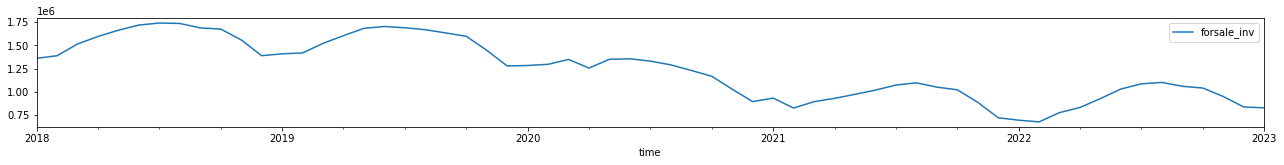

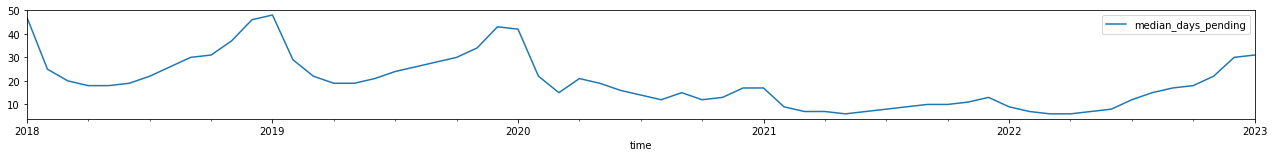

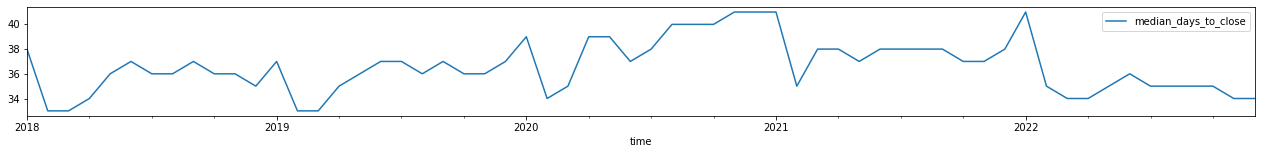

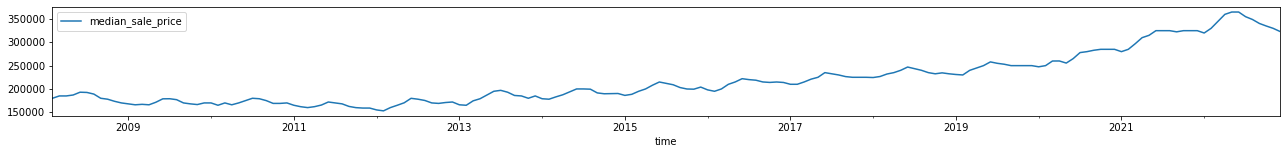

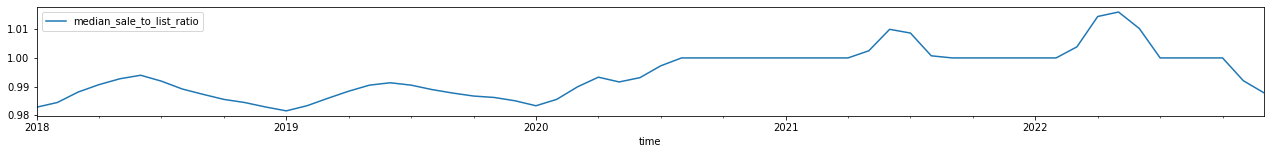

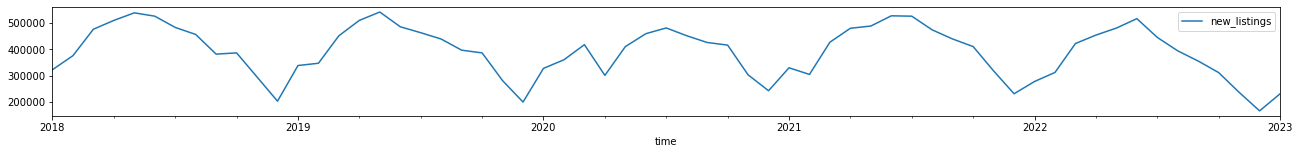

In [11]:
us_ts = []

for df in pp_dfs:
    us_df = df[df['RegionName'] == 'United States']
    us_df.drop(id_vars, axis=1, inplace=True)
    us_df.set_index('time', inplace=True)
    us_ts.append(us_df)
    
    us_df.plot(figsize=(22,2));

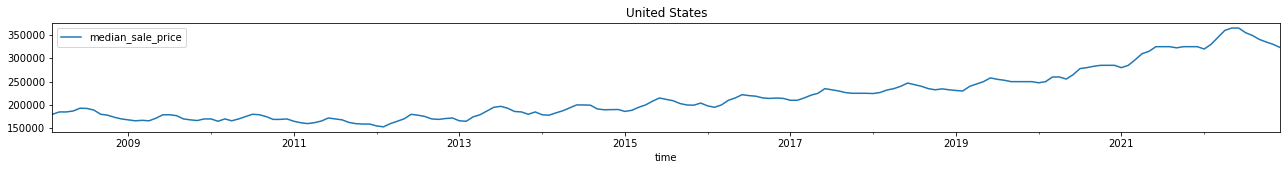

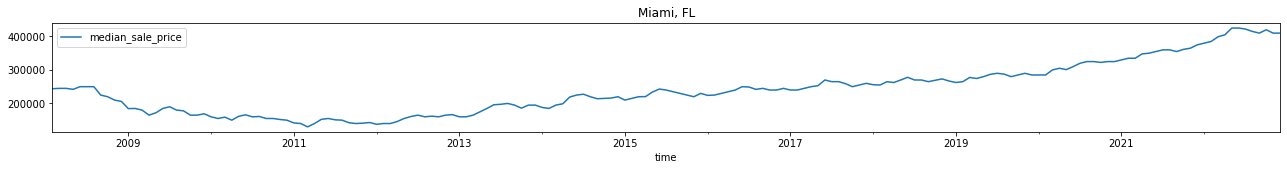

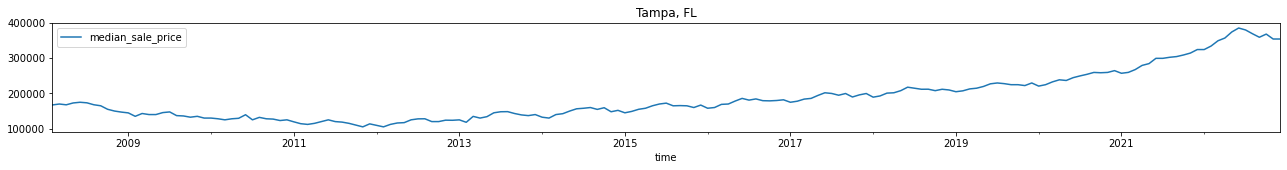

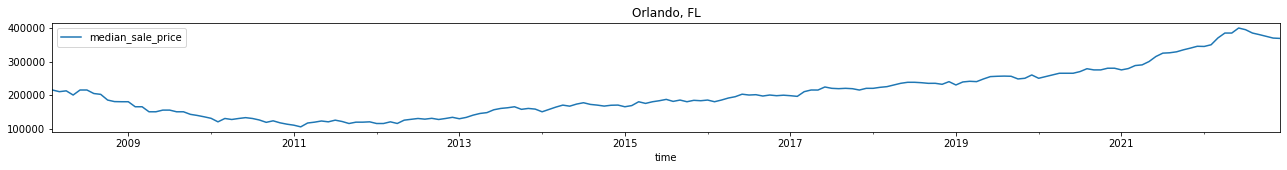

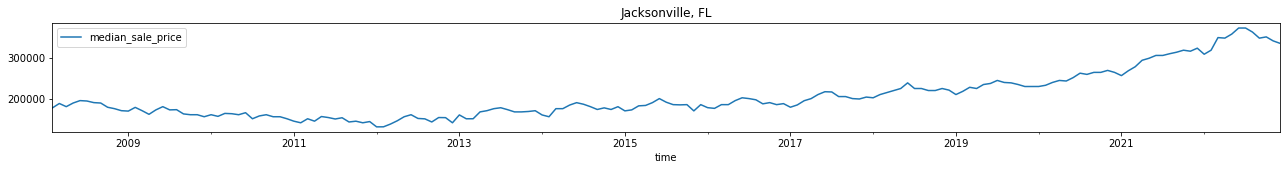

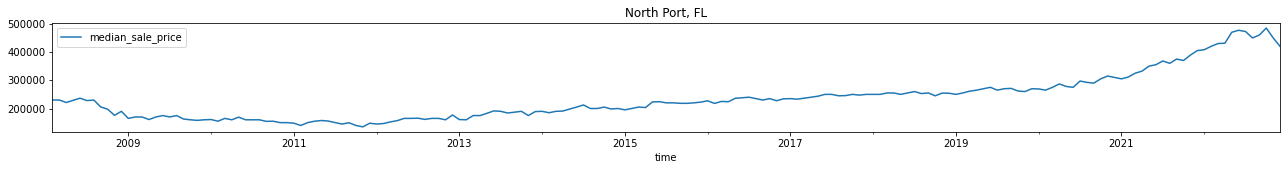

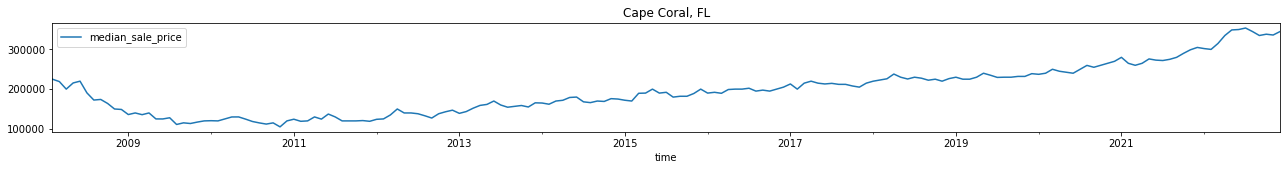

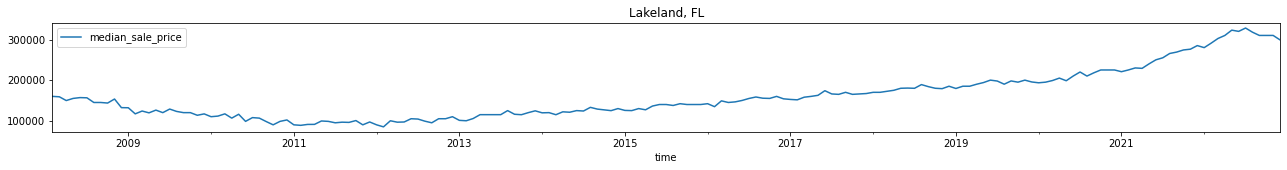

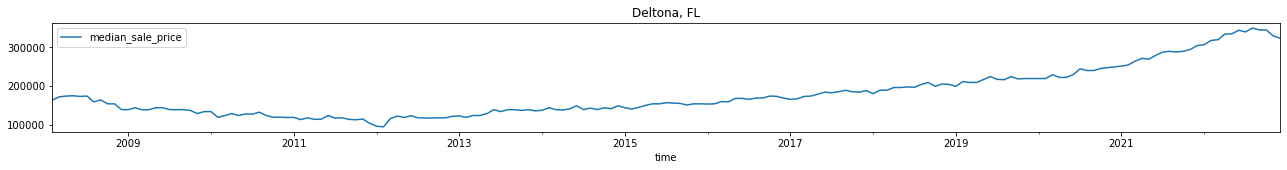

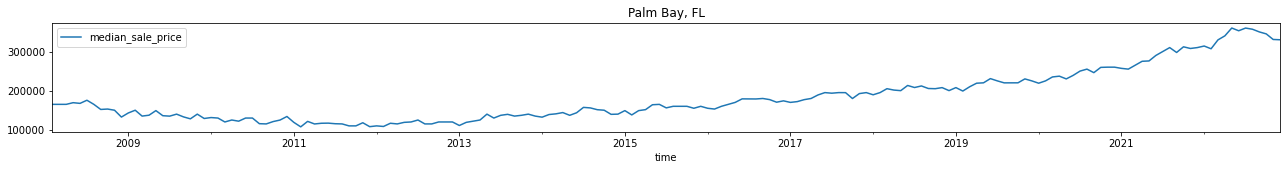

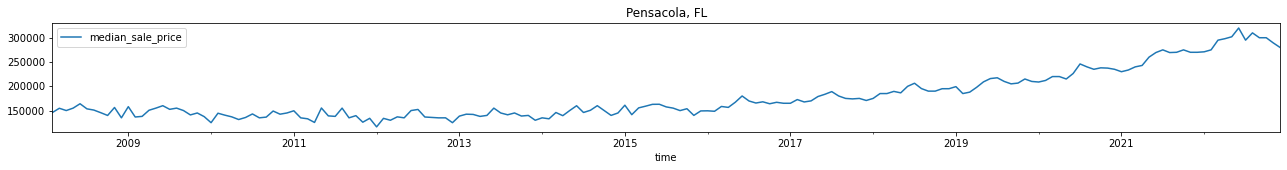

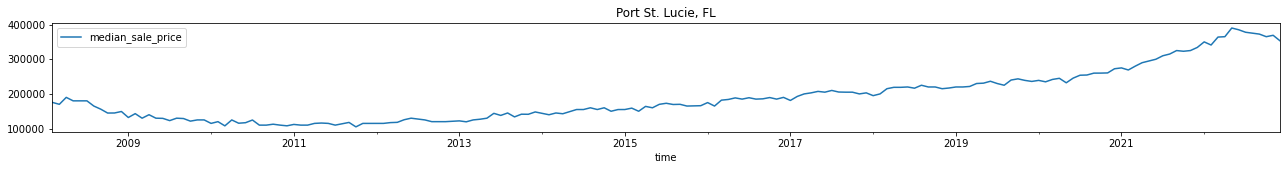

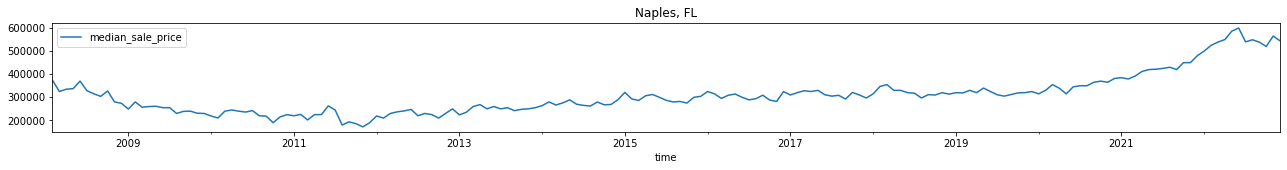

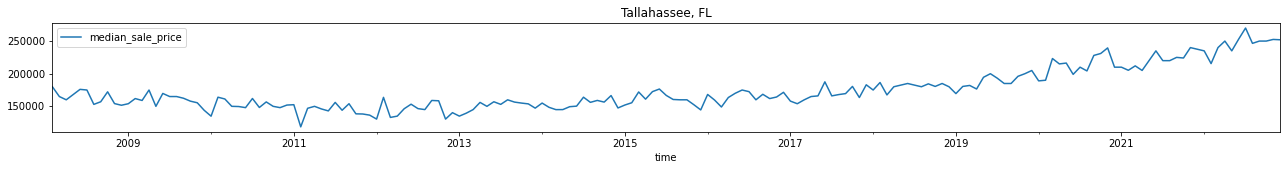

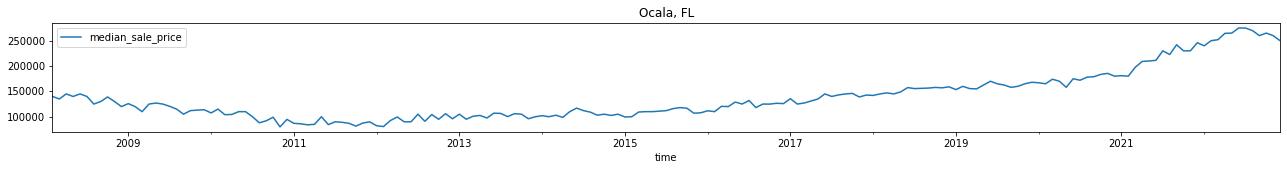

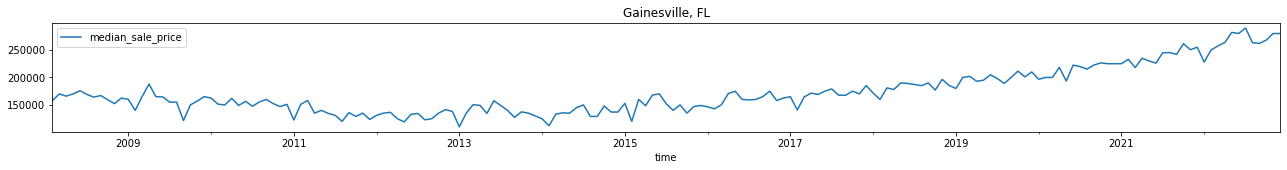

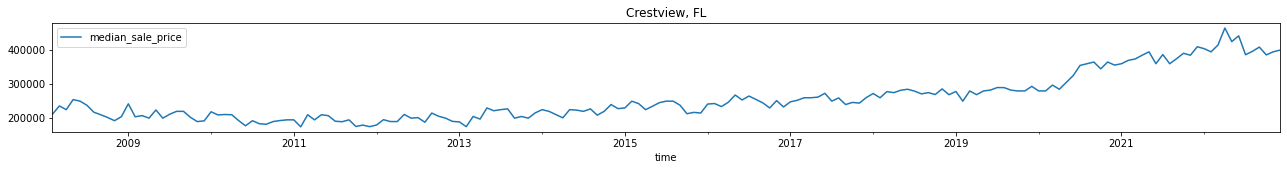

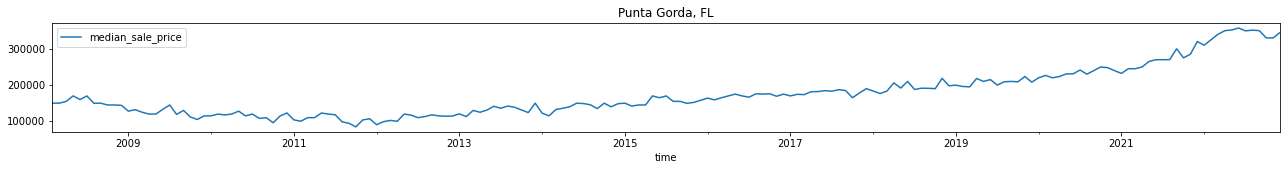

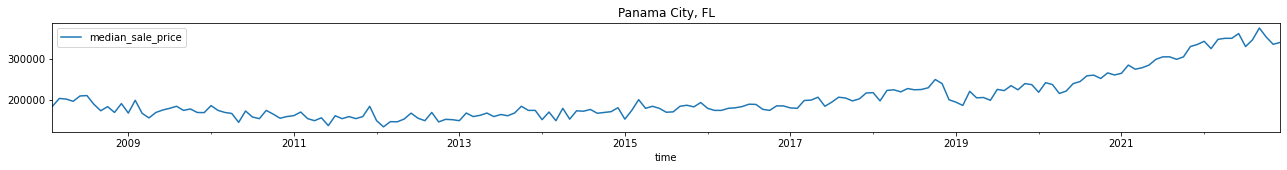

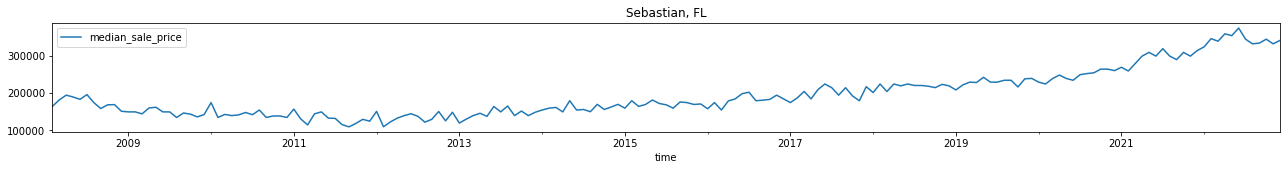

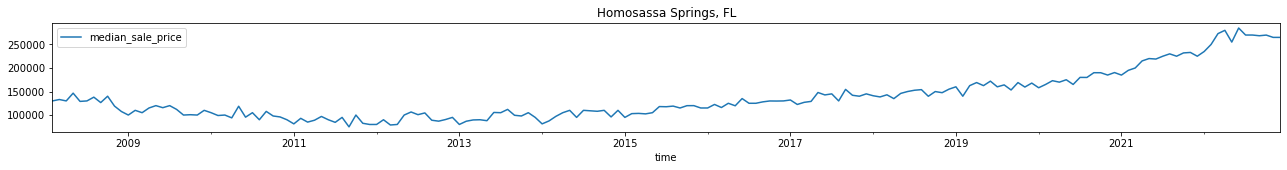

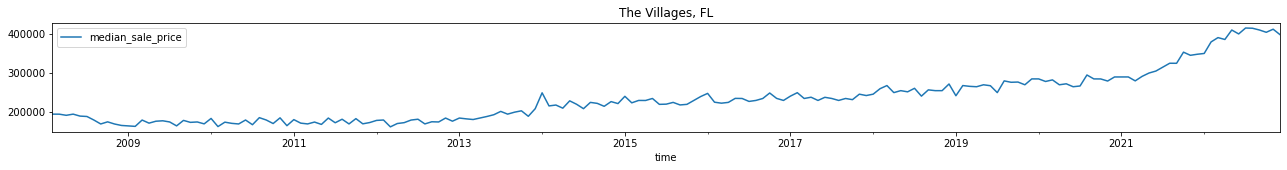

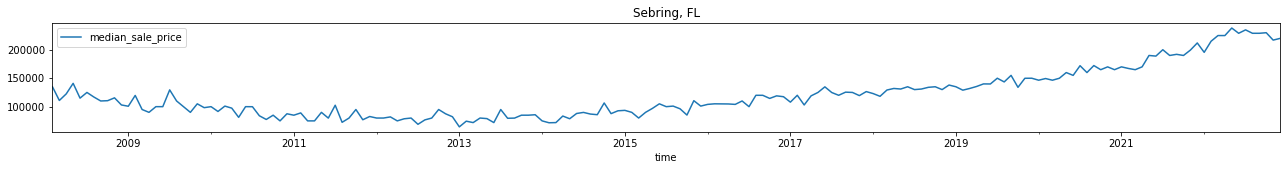

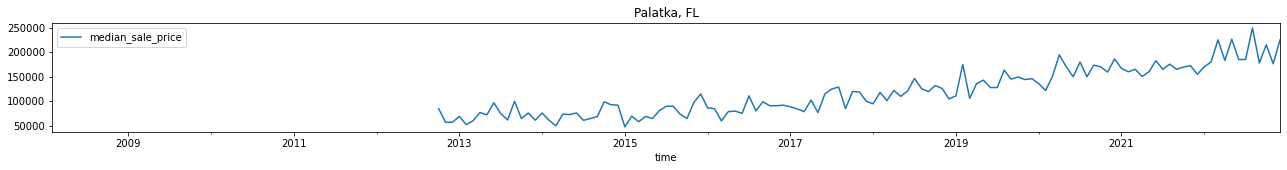

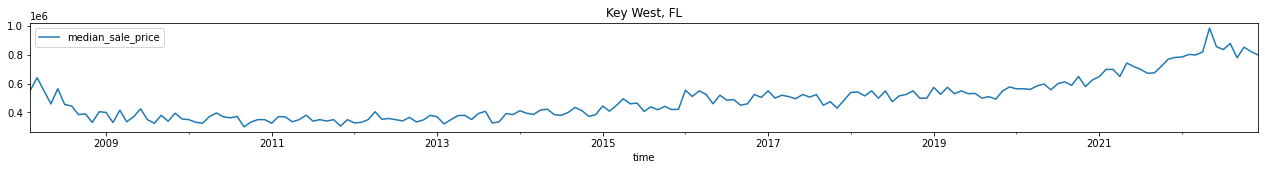

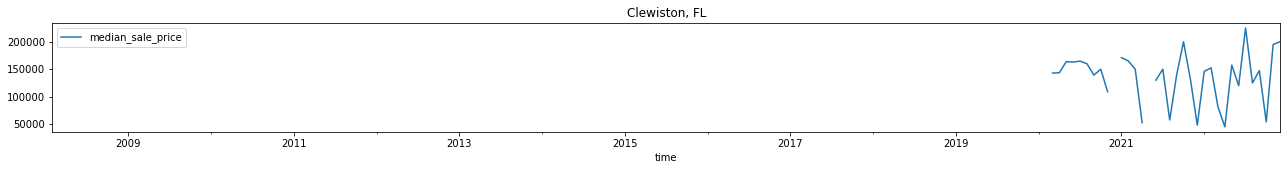

In [12]:
sale_price_loc = []
sale_price_ts = []
create_ts(sale_price_loc, sale_price_ts, id_vars, med_sp)

In [13]:
med_sp[med_sp['time'] == '2022-12-31'].sort_values(by='median_sale_price', ascending=False)

RegionID  SizeRank             RegionName RegionType StateName  \
4652    394744       467           Key West, FL        msa        FL   
4640    394901       139             Naples, FL        msa        FL   
4633    753906        67         North Port, FL        msa        FL   
4629    394856         7              Miami, FL        msa        FL   
4644    753875       170          Crestview, FL        msa        FL   
4649    395153       308       The Villages, FL        msa        FL   
4631    394943        23            Orlando, FL        msa        FL   
4630    395148        18              Tampa, FL        msa        FL   
4639    394995       112     Port St. Lucie, FL        msa        FL   
4645    395009       230        Punta Gorda, FL        msa        FL   
4634    394440        75         Cape Coral, FL        msa        FL   
4647    395079       268          Sebastian, FL        msa        FL   
4646    394960       252        Panama City, FL        msa        FL   
4632    394714        39       Jacksonville, FL        msa        FL   
4637    394957        96           Palm Bay, FL        msa        FL   
4636    394528        86            Deltona, FL        msa        FL   
178     102001         0          United States    country       NaN   
4635    394766        81           Lakeland, FL        msa        FL   
4638    394971       111          Pensacola, FL        msa        FL   
4643    394622       155        Gainesville, FL        msa        FL   
4648    394685       277  Homosassa Springs, FL        msa        FL   
4641    395146       142        Tallahassee, FL        msa        FL   
4642    394927       145              Ocala, FL        msa        FL   
4651    394955       463            Palatka, FL        msa        FL   
4650    395080       368            Sebring, FL        msa        FL   
4653    394476       669          Clewiston, FL        msa        FL   

           time  median_sale_price  
4652 2022-12-31           800000.0  
4640 2022-12-31           544500.0  
4633 2022-12-31           420000.0  
4629 2022-12-31           410000.0  
4644 2022-12-31           400000.0  
4649 2022-12-31           398000.0  
4631 2022-12-31           369000.0  
4630 2022-12-31           355000.0  
4639 2022-12-31           353000.0  
4645 2022-12-31           345000.0  
4634 2022-12-31           345000.0  
4647 2022-12-31           342250.0  
4646 2022-12-31           340000.0  
4632 2022-12-31           337000.0  
4637 2022-12-31           330000.0  
4636 2022-12-31           323675.0  
178  2022-12-31           323225.0  
4635 2022-12-31           299000.0  
4638 2022-12-31           280000.0  
4643 2022-12-31           280000.0  
4648 2022-12-31           265000.0  
4641 2022-12-31           252000.0  
4642 2022-12-31           250000.0  
4651 2022-12-31           225000.0  
4650 2022-12-31           220000.0  
4653 2022-12-31           200000.0

In [14]:
sale_to_list = pp_dfs[4]
sale_to_list

RegionID  SizeRank        RegionName RegionType StateName       time  \
0       102001         0     United States    country       NaN 2018-01-31   
1       102001         0     United States    country       NaN 2018-02-28   
2       102001         0     United States    country       NaN 2018-03-31   
3       102001         0     United States    country       NaN 2018-04-30   
4       102001         0     United States    country       NaN 2018-05-31   
...        ...       ...               ...        ...       ...        ...   
1555    395153       308  The Villages, FL        msa        FL 2022-12-31   
1556    395080       368       Sebring, FL        msa        FL 2022-12-31   
1557    394955       463       Palatka, FL        msa        FL 2022-12-31   
1558    394744       467      Key West, FL        msa        FL 2022-12-31   
1559    394476       669     Clewiston, FL        msa        FL 2022-12-31   

      median_sale_to_list_ratio  
0                      0.982759  
1                      0.984410  
2                      0.988071  
3                      0.990654  
4                      0.992701  
...                         ...  
1555                   0.972119  
1556                   0.966989  
1557                   0.952183  
1558                   0.965665  
1559                   0.979487  

[1560 rows x 7 columns]

In [15]:
sale_to_list[sale_to_list['time'] == '2022-12-31'].sort_values(by='median_sale_to_list_ratio', ascending=False)

RegionID  SizeRank             RegionName RegionType StateName  \
59      102001         0          United States    country       NaN   
1544    394971       111          Pensacola, FL        msa        FL   
1547    395146       142        Tallahassee, FL        msa        FL   
1541    394766        81           Lakeland, FL        msa        FL   
1537    394943        23            Orlando, FL        msa        FL   
1559    394476       669          Clewiston, FL        msa        FL   
1545    394995       112     Port St. Lucie, FL        msa        FL   
1536    395148        18              Tampa, FL        msa        FL   
1543    394957        96           Palm Bay, FL        msa        FL   
1542    394528        86            Deltona, FL        msa        FL   
1548    394927       145              Ocala, FL        msa        FL   
1538    394714        39       Jacksonville, FL        msa        FL   
1550    753875       170          Crestview, FL        msa        FL   
1549    394622       155        Gainesville, FL        msa        FL   
1552    394960       252        Panama City, FL        msa        FL   
1540    394440        75         Cape Coral, FL        msa        FL   
1535    394856         7              Miami, FL        msa        FL   
1539    753906        67         North Port, FL        msa        FL   
1555    395153       308       The Villages, FL        msa        FL   
1554    394685       277  Homosassa Springs, FL        msa        FL   
1553    395079       268          Sebastian, FL        msa        FL   
1551    395009       230        Punta Gorda, FL        msa        FL   
1556    395080       368            Sebring, FL        msa        FL   
1558    394744       467           Key West, FL        msa        FL   
1546    394901       139             Naples, FL        msa        FL   
1557    394955       463            Palatka, FL        msa        FL   

           time  median_sale_to_list_ratio  
59   2022-12-31                   0.987747  
1544 2022-12-31                   0.984683  
1547 2022-12-31                   0.982759  
1541 2022-12-31                   0.982222  
1537 2022-12-31                   0.981114  
1559 2022-12-31                   0.979487  
1545 2022-12-31                   0.978892  
1536 2022-12-31                   0.977780  
1543 2022-12-31                   0.977700  
1542 2022-12-31                   0.977156  
1548 2022-12-31                   0.977095  
1538 2022-12-31                   0.976700  
1550 2022-12-31                   0.976682  
1549 2022-12-31                   0.976266  
1552 2022-12-31                   0.976220  
1540 2022-12-31                   0.973727  
1535 2022-12-31                   0.973333  
1539 2022-12-31                   0.972745  
1555 2022-12-31                   0.972119  
1554 2022-12-31                   0.970404  
1553 2022-12-31                   0.970172  
1551 2022-12-31                   0.970149  
1556 2022-12-31                   0.966989  
1558 2022-12-31                   0.965665  
1546 2022-12-31                   0.964668  
1557 2022-12-31                   0.952183

In [16]:
forsale_inv = pp_dfs[0]
forsale_inv

RegionID  SizeRank      RegionName RegionType StateName       time  \
0       102001         0   United States    country       NaN 2018-01-31   
1       102001         0   United States    country       NaN 2018-02-28   
2       102001         0   United States    country       NaN 2018-03-31   
3       102001         0   United States    country       NaN 2018-04-30   
4       102001         0   United States    country       NaN 2018-05-31   
...        ...       ...             ...        ...       ...        ...   
1825    394764       471   Lake City, FL        msa        FL 2023-01-31   
1826    394476       669   Clewiston, FL        msa        FL 2023-01-31   
1827    394934       674  Okeechobee, FL        msa        FL 2023-01-31   
1828    394335       706     Arcadia, FL        msa        FL 2023-01-31   
1829    395214       835    Wauchula, FL        msa        FL 2023-01-31   

      forsale_inv  
0       1360756.0  
1       1388126.0  
2       1515704.0  
3       1596749.0  
4       1664787.0  
...           ...  
1825        402.0  
1826        479.0  
1827        177.0  
1828         96.0  
1829         47.0  

[1830 rows x 7 columns]

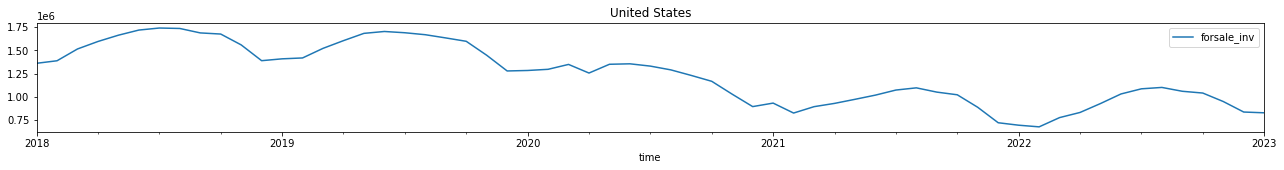

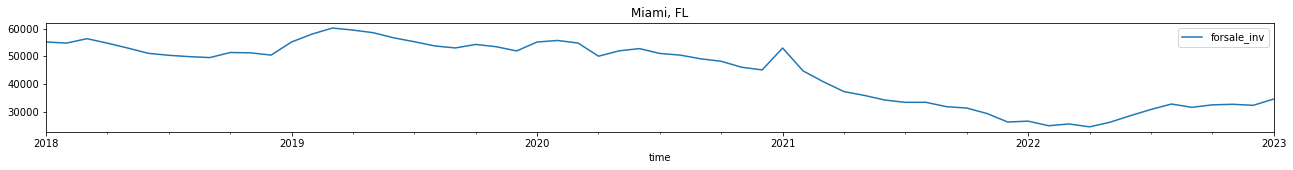

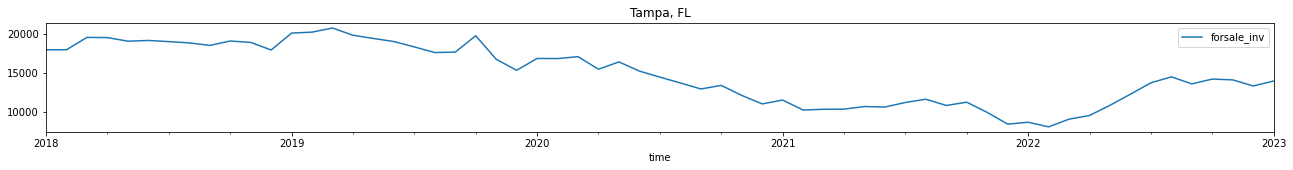

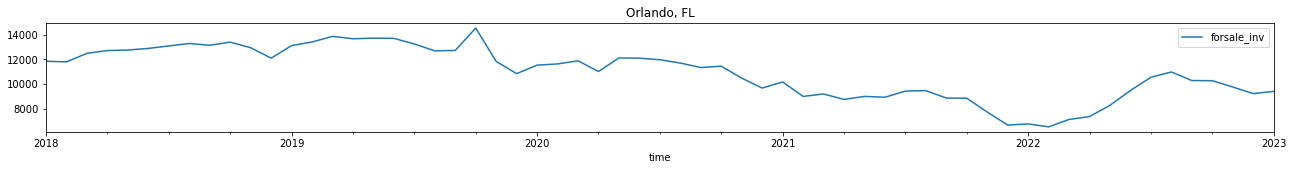

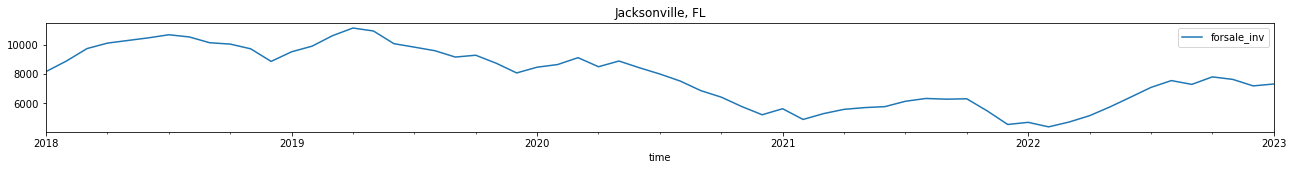

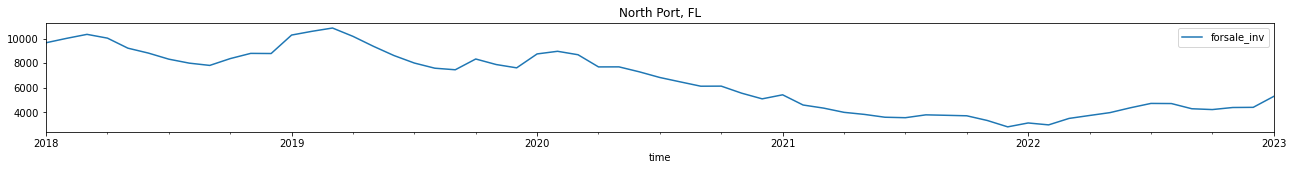

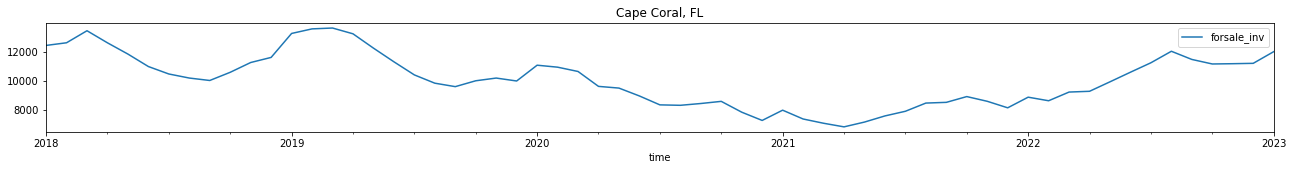

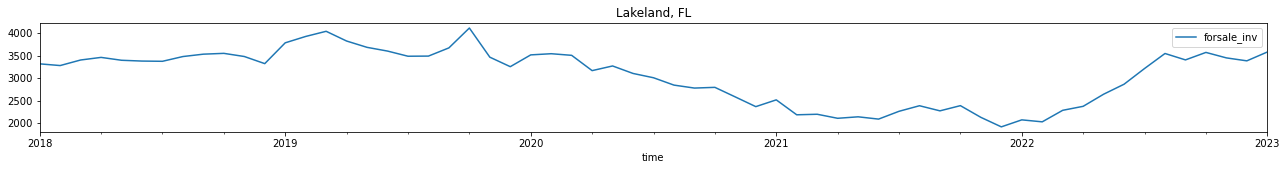

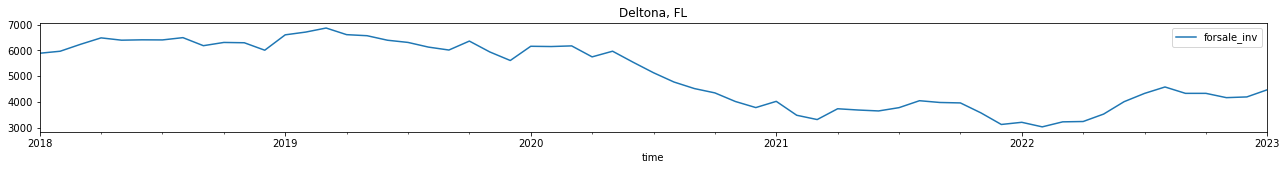

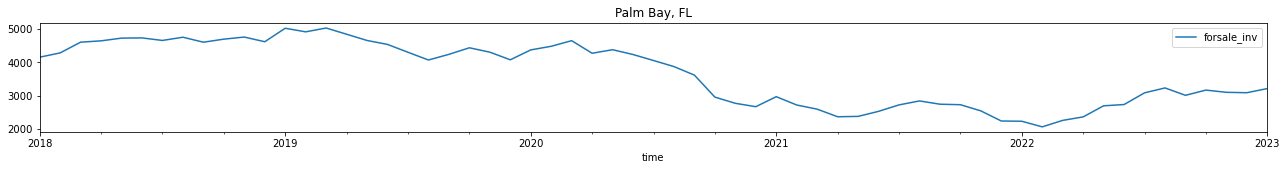

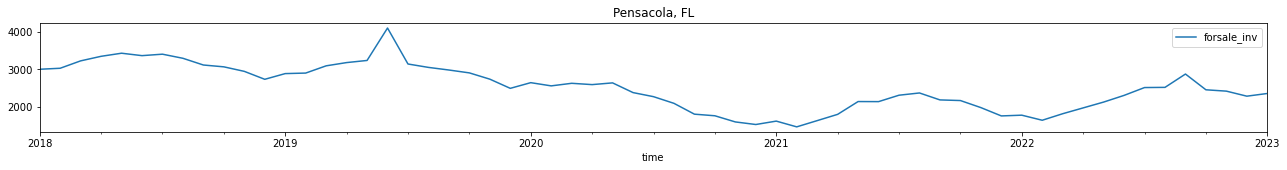

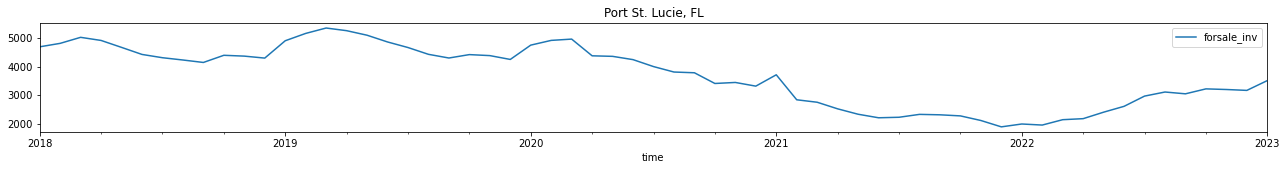

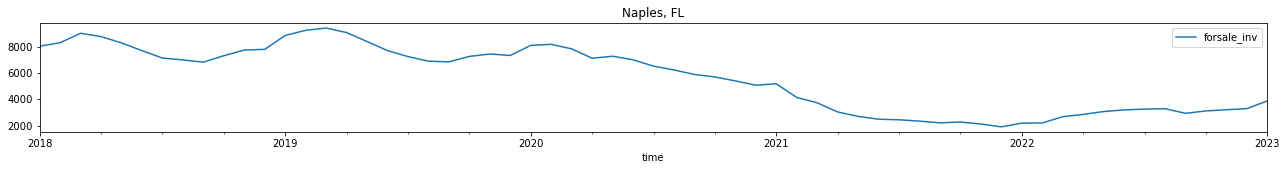

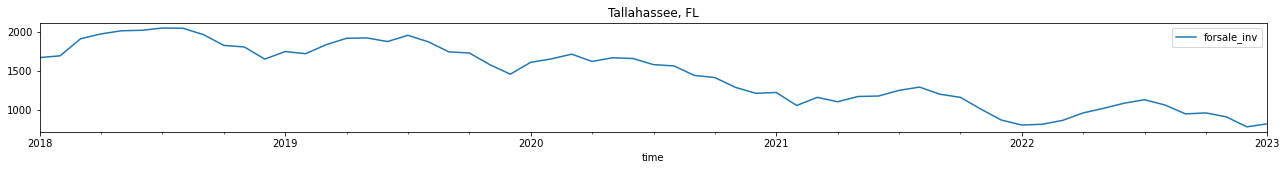

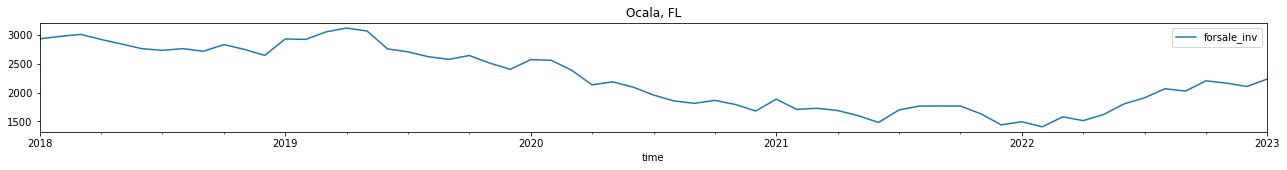

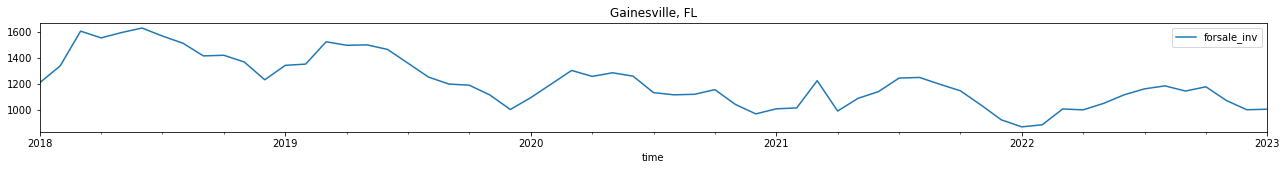

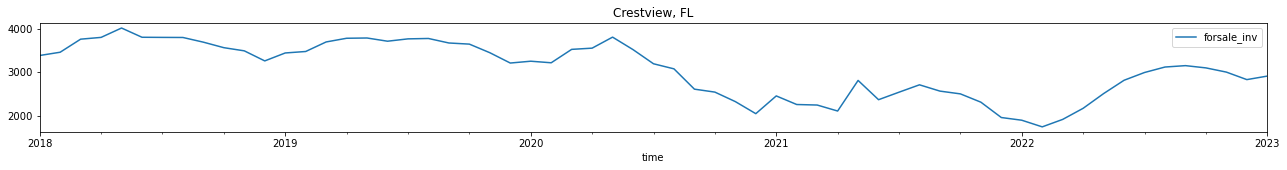

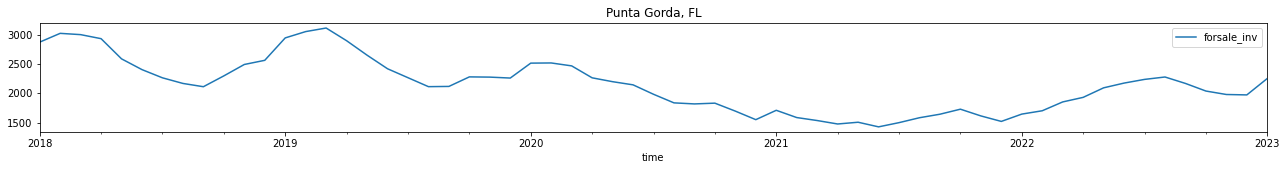

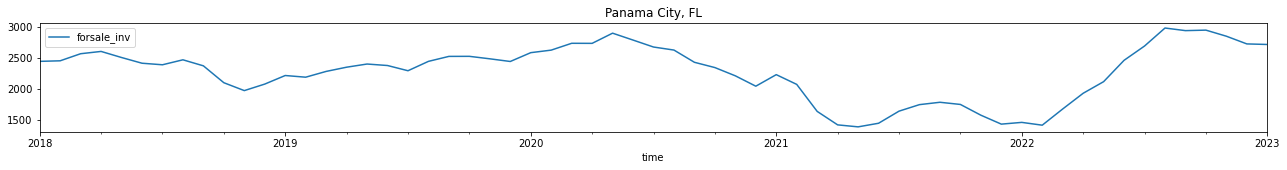

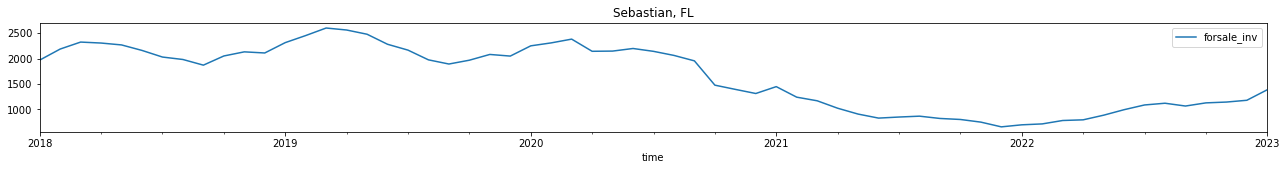

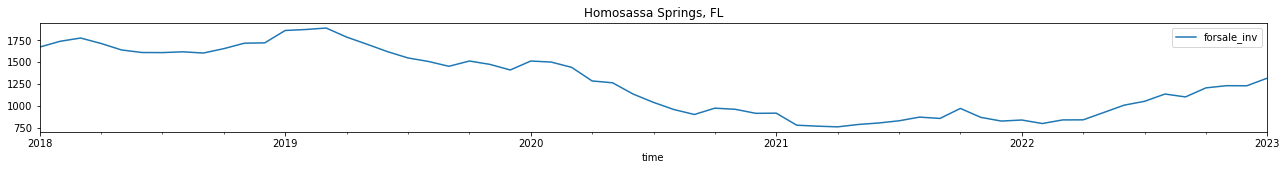

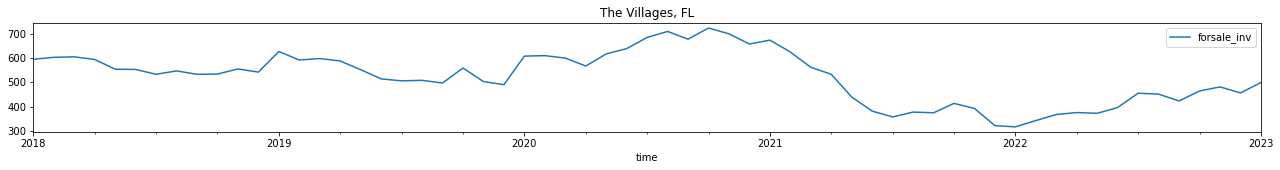

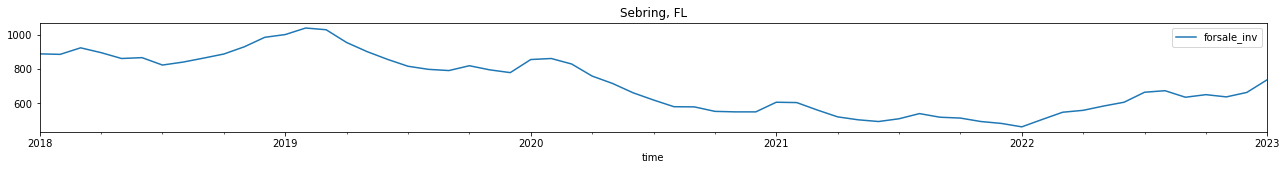

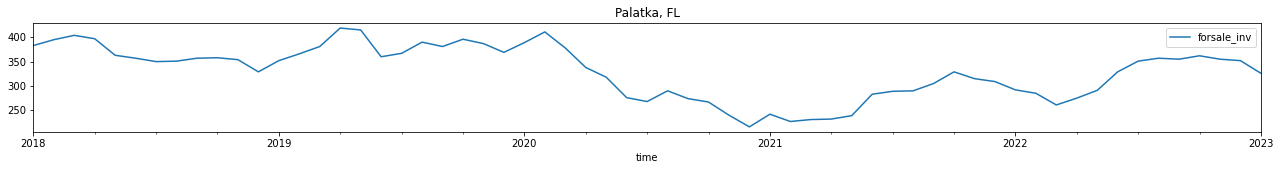

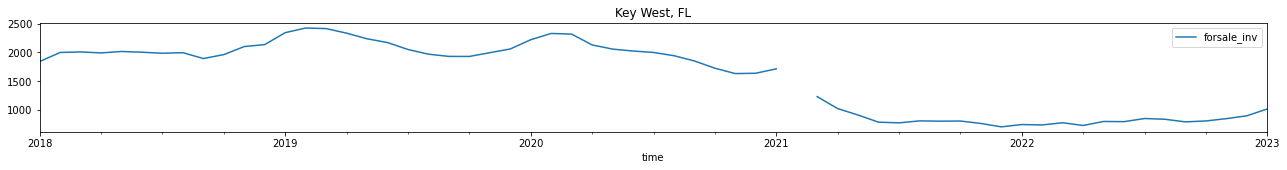

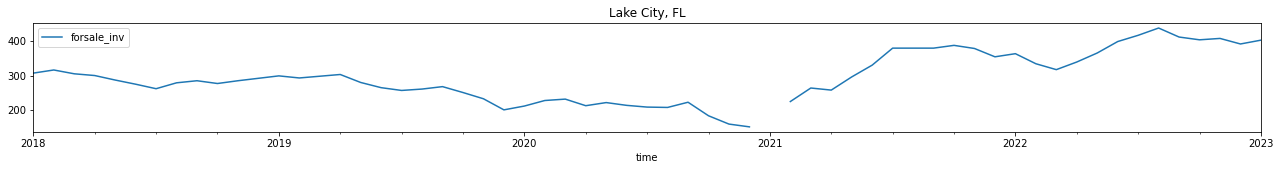

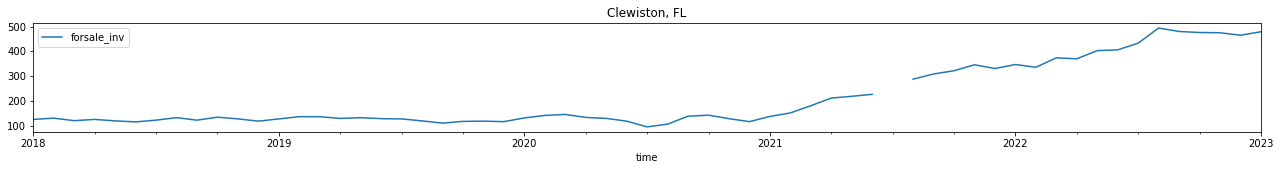

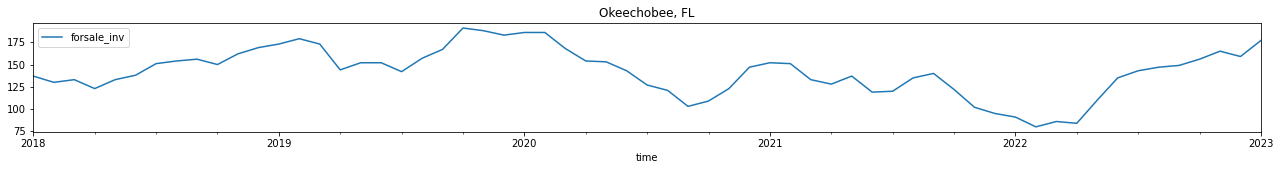

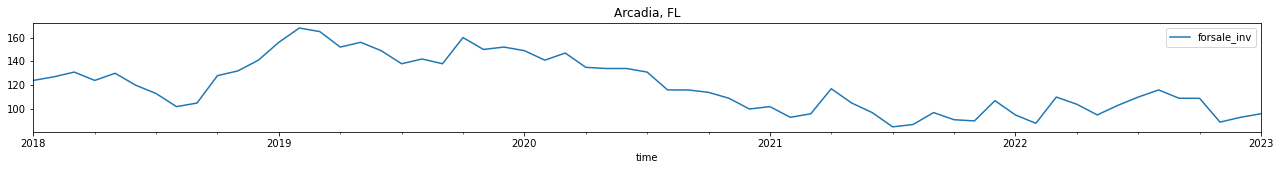

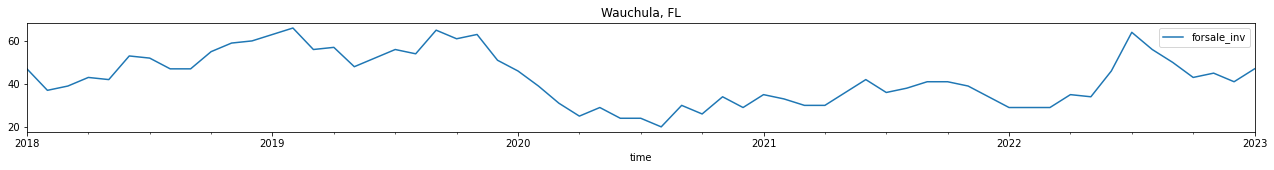

In [17]:
inv_loc = []
inv_ts = []
create_ts(inv_loc, inv_ts, id_vars, forsale_inv)

In [18]:
forsale_inv[forsale_inv['time'] == '2022-12-31'].sort_values(by='forsale_inv', ascending=False)

RegionID  SizeRank             RegionName RegionType StateName  \
59      102001         0          United States    country       NaN   
1772    394856         7              Miami, FL        msa        FL   
1773    395148        18              Tampa, FL        msa        FL   
1777    394440        75         Cape Coral, FL        msa        FL   
1774    394943        23            Orlando, FL        msa        FL   
1775    394714        39       Jacksonville, FL        msa        FL   
1776    753906        67         North Port, FL        msa        FL   
1779    394528        86            Deltona, FL        msa        FL   
1778    394766        81           Lakeland, FL        msa        FL   
1783    394901       139             Naples, FL        msa        FL   
1782    394995       112     Port St. Lucie, FL        msa        FL   
1780    394957        96           Palm Bay, FL        msa        FL   
1787    753875       170          Crestview, FL        msa        FL   
1789    394960       252        Panama City, FL        msa        FL   
1781    394971       111          Pensacola, FL        msa        FL   
1785    394927       145              Ocala, FL        msa        FL   
1788    395009       230        Punta Gorda, FL        msa        FL   
1791    394685       277  Homosassa Springs, FL        msa        FL   
1790    395079       268          Sebastian, FL        msa        FL   
1786    394622       155        Gainesville, FL        msa        FL   
1795    394744       467           Key West, FL        msa        FL   
1784    395146       142        Tallahassee, FL        msa        FL   
1793    395080       368            Sebring, FL        msa        FL   
1797    394476       669          Clewiston, FL        msa        FL   
1792    395153       308       The Villages, FL        msa        FL   
1796    394764       471          Lake City, FL        msa        FL   
1794    394955       463            Palatka, FL        msa        FL   
1798    394934       674         Okeechobee, FL        msa        FL   
1799    394335       706            Arcadia, FL        msa        FL   
1800    395214       835           Wauchula, FL        msa        FL   

           time  forsale_inv  
59   2022-12-31     833473.0  
1772 2022-12-31      32240.0  
1773 2022-12-31      13352.0  
1777 2022-12-31      11207.0  
1774 2022-12-31       9227.0  
1775 2022-12-31       7190.0  
1776 2022-12-31       4417.0  
1779 2022-12-31       4194.0  
1778 2022-12-31       3386.0  
1783 2022-12-31       3298.0  
1782 2022-12-31       3170.0  
1780 2022-12-31       3089.0  
1787 2022-12-31       2828.0  
1789 2022-12-31       2727.0  
1781 2022-12-31       2283.0  
1785 2022-12-31       2104.0  
1788 2022-12-31       1973.0  
1791 2022-12-31       1233.0  
1790 2022-12-31       1180.0  
1786 2022-12-31       1002.0  
1795 2022-12-31        906.0  
1784 2022-12-31        788.0  
1793 2022-12-31        664.0  
1797 2022-12-31        465.0  
1792 2022-12-31        456.0  
1796 2022-12-31        391.0  
1794 2022-12-31        352.0  
1798 2022-12-31        159.0  
1799 2022-12-31         93.0  
1800 2022-12-31         41.0

In [19]:
new_listings = pp_dfs[-1]
new_listings

RegionID  SizeRank      RegionName RegionType StateName       time  \
0       102001         0   United States    country       NaN 2018-01-31   
1       102001         0   United States    country       NaN 2018-02-28   
2       102001         0   United States    country       NaN 2018-03-31   
3       102001         0   United States    country       NaN 2018-04-30   
4       102001         0   United States    country       NaN 2018-05-31   
...        ...       ...             ...        ...       ...        ...   
1825    394764       471   Lake City, FL        msa        FL 2023-01-31   
1826    394476       669   Clewiston, FL        msa        FL 2023-01-31   
1827    394934       674  Okeechobee, FL        msa        FL 2023-01-31   
1828    394335       706     Arcadia, FL        msa        FL 2023-01-31   
1829    395214       835    Wauchula, FL        msa        FL 2023-01-31   

      new_listings  
0         323255.0  
1         376081.0  
2         476113.0  
3         509438.0  
4         538099.0  
...            ...  
1825          88.0  
1826          84.0  
1827          47.0  
1828          29.0  
1829          14.0  

[1830 rows x 7 columns]

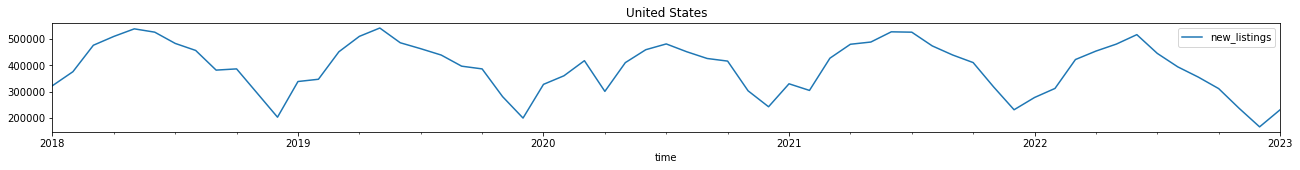

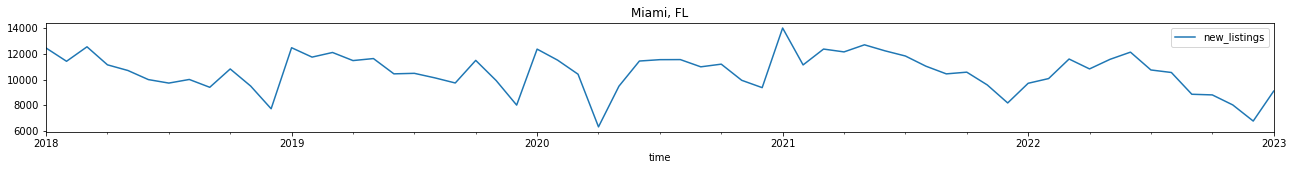

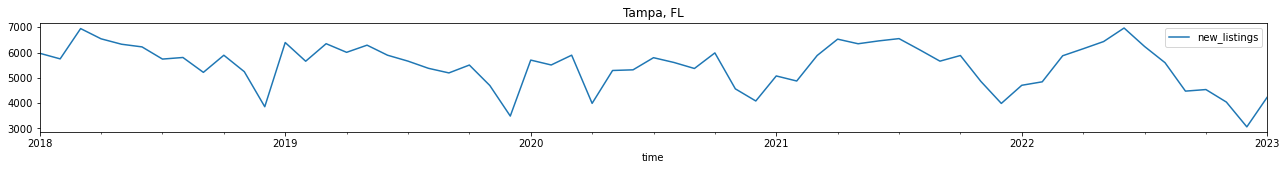

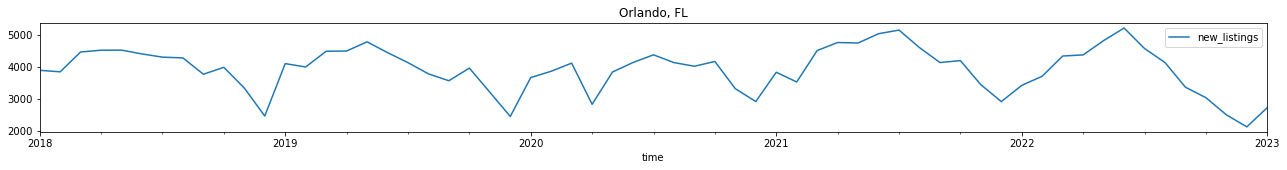

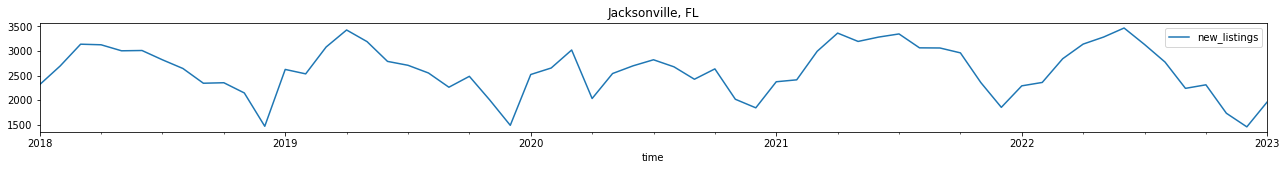

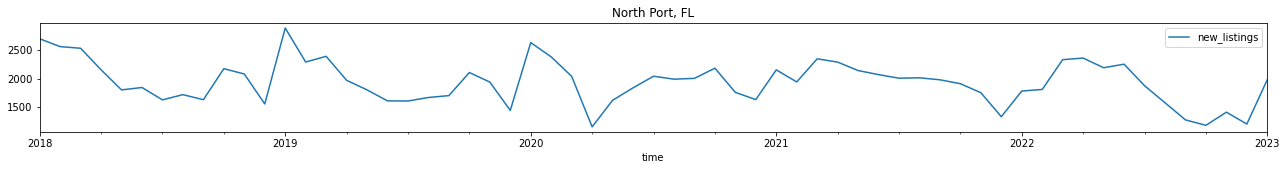

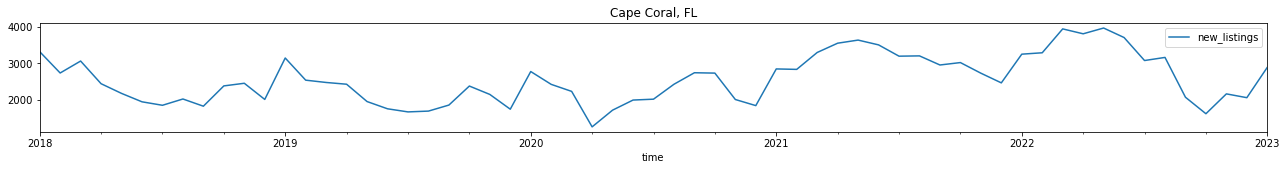

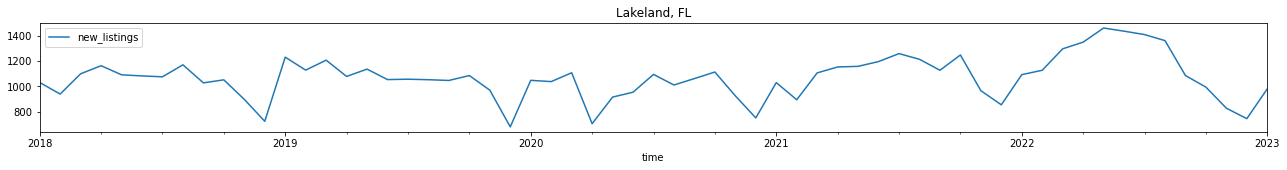

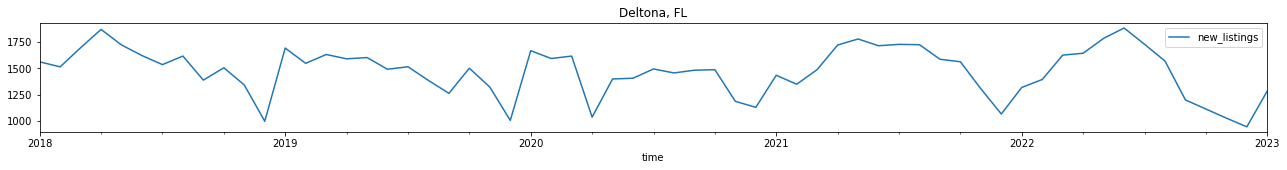

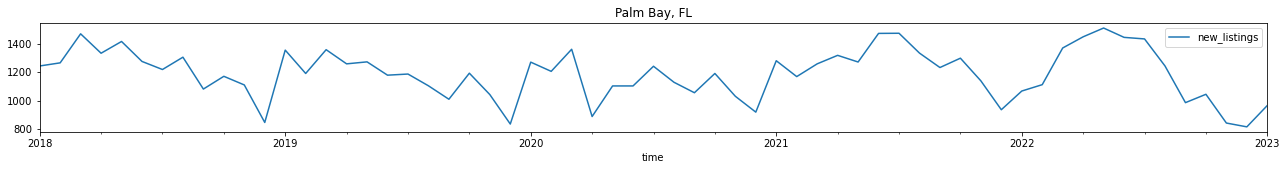

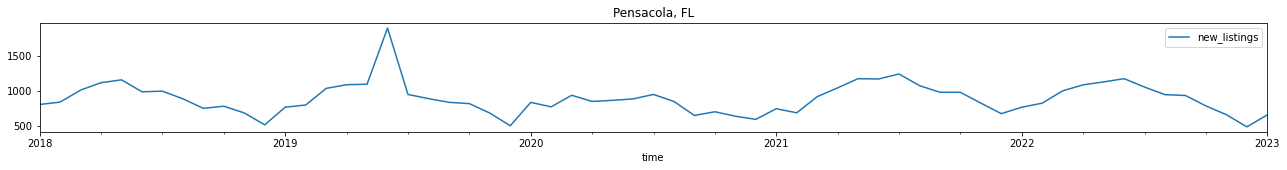

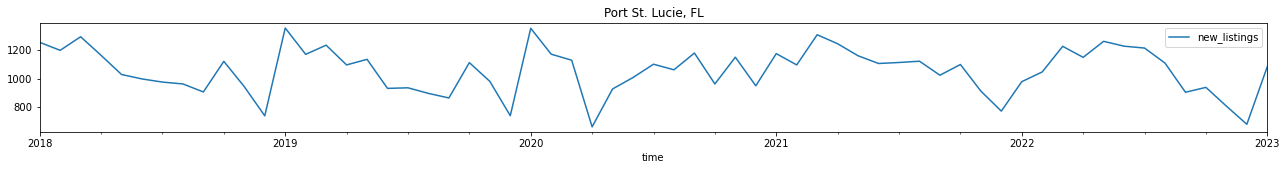

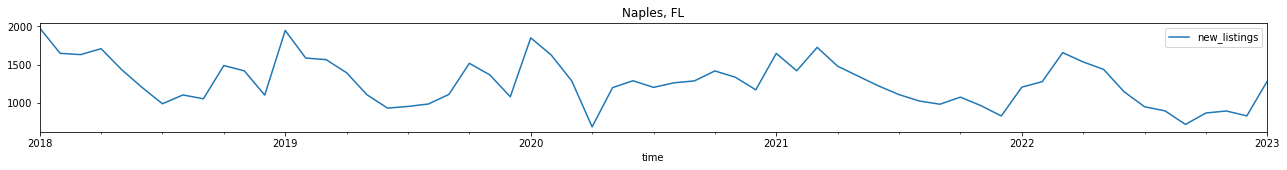

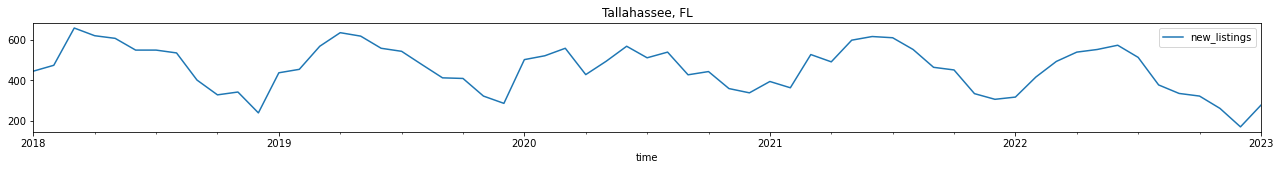

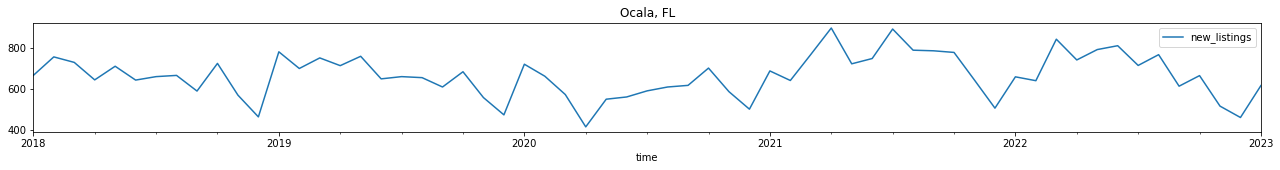

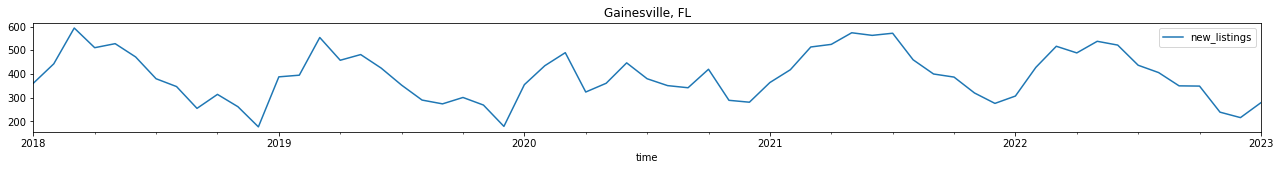

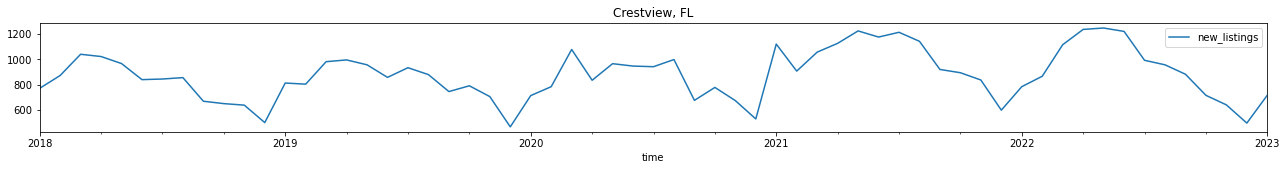

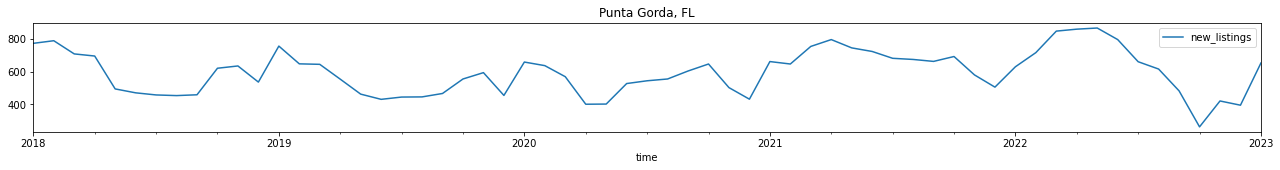

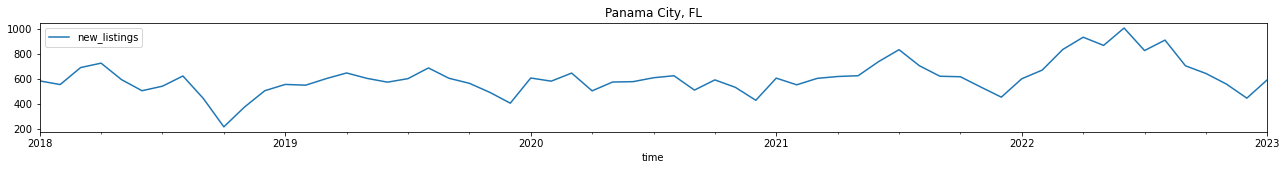

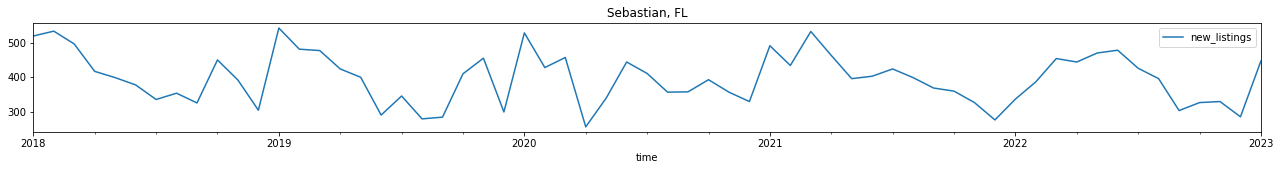

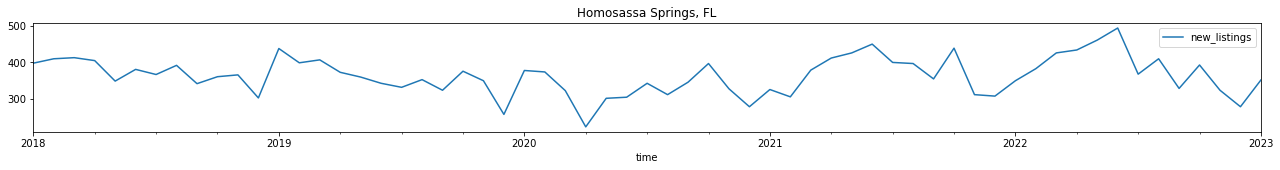

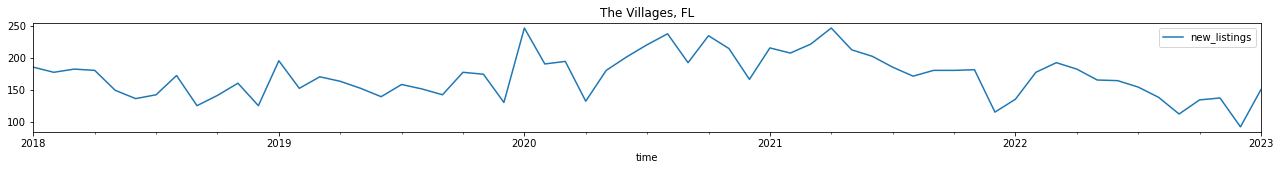

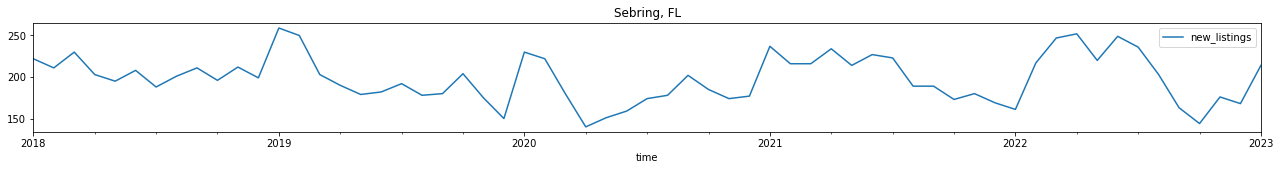

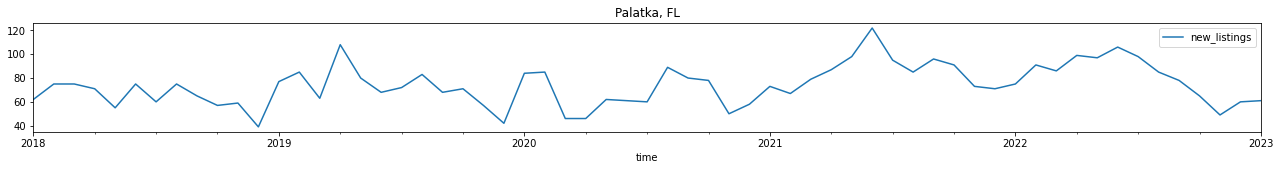

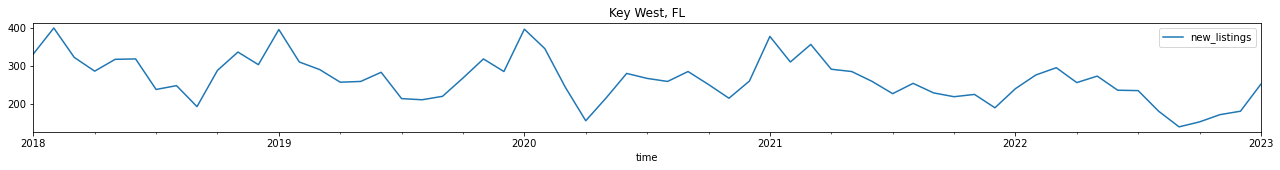

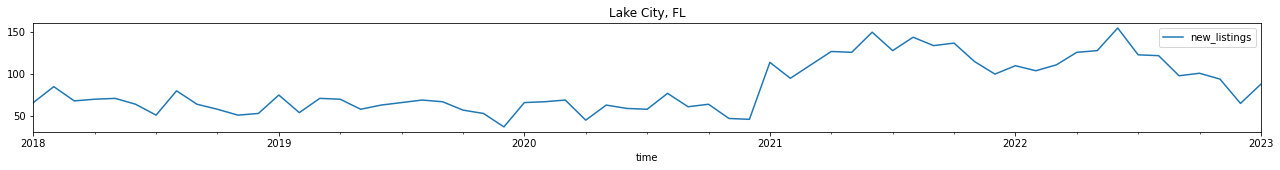

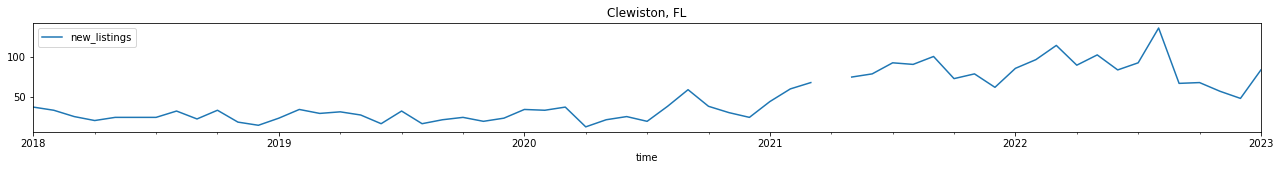

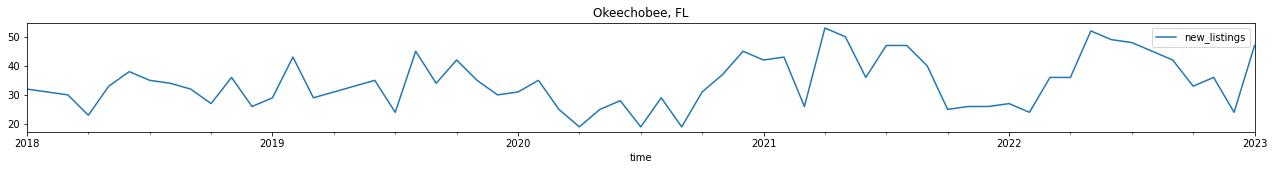

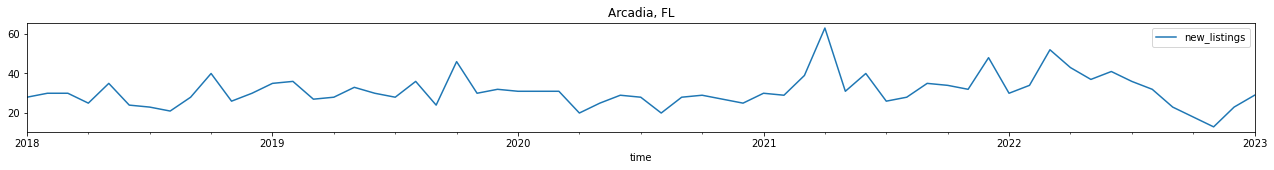

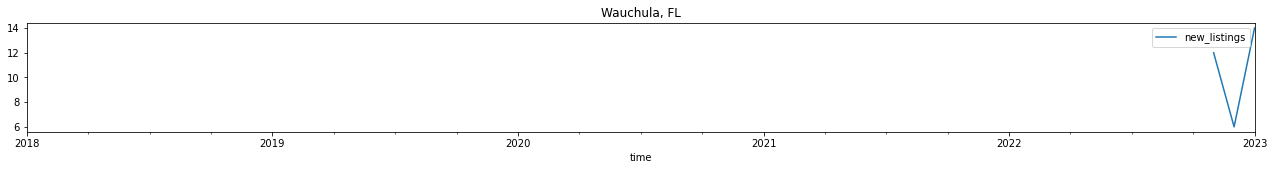

In [20]:
new_listings_loc = []
new_listings_ts = []
create_ts(new_listings_loc, new_listings_ts, id_vars, new_listings)

In [21]:
new_listings[new_listings['time'] == '2022-12-31'].sort_values(by='new_listings', ascending=False)

RegionID  SizeRank             RegionName RegionType StateName  \
59      102001         0          United States    country       NaN   
1772    394856         7              Miami, FL        msa        FL   
1773    395148        18              Tampa, FL        msa        FL   
1774    394943        23            Orlando, FL        msa        FL   
1777    394440        75         Cape Coral, FL        msa        FL   
1775    394714        39       Jacksonville, FL        msa        FL   
1776    753906        67         North Port, FL        msa        FL   
1779    394528        86            Deltona, FL        msa        FL   
1783    394901       139             Naples, FL        msa        FL   
1780    394957        96           Palm Bay, FL        msa        FL   
1778    394766        81           Lakeland, FL        msa        FL   
1782    394995       112     Port St. Lucie, FL        msa        FL   
1787    753875       170          Crestview, FL        msa        FL   
1781    394971       111          Pensacola, FL        msa        FL   
1785    394927       145              Ocala, FL        msa        FL   
1789    394960       252        Panama City, FL        msa        FL   
1788    395009       230        Punta Gorda, FL        msa        FL   
1790    395079       268          Sebastian, FL        msa        FL   
1791    394685       277  Homosassa Springs, FL        msa        FL   
1786    394622       155        Gainesville, FL        msa        FL   
1795    394744       467           Key West, FL        msa        FL   
1784    395146       142        Tallahassee, FL        msa        FL   
1793    395080       368            Sebring, FL        msa        FL   
1792    395153       308       The Villages, FL        msa        FL   
1796    394764       471          Lake City, FL        msa        FL   
1794    394955       463            Palatka, FL        msa        FL   
1797    394476       669          Clewiston, FL        msa        FL   
1798    394934       674         Okeechobee, FL        msa        FL   
1799    394335       706            Arcadia, FL        msa        FL   
1800    395214       835           Wauchula, FL        msa        FL   

           time  new_listings  
59   2022-12-31      167642.0  
1772 2022-12-31        6776.0  
1773 2022-12-31        3062.0  
1774 2022-12-31        2131.0  
1777 2022-12-31        2064.0  
1775 2022-12-31        1462.0  
1776 2022-12-31        1200.0  
1779 2022-12-31         946.0  
1783 2022-12-31         826.0  
1780 2022-12-31         814.0  
1778 2022-12-31         744.0  
1782 2022-12-31         681.0  
1787 2022-12-31         493.0  
1781 2022-12-31         486.0  
1785 2022-12-31         460.0  
1789 2022-12-31         447.0  
1788 2022-12-31         395.0  
1790 2022-12-31         286.0  
1791 2022-12-31         279.0  
1786 2022-12-31         216.0  
1795 2022-12-31         182.0  
1784 2022-12-31         171.0  
1793 2022-12-31         168.0  
1792 2022-12-31          93.0  
1796 2022-12-31          65.0  
1794 2022-12-31          60.0  
1797 2022-12-31          48.0  
1798 2022-12-31          24.0  
1799 2022-12-31          23.0  
1800 2022-12-31           6.0

In [22]:
days_to_close = pp_dfs[2]
days_to_close

RegionID  SizeRank        RegionName RegionType StateName       time  \
0       102001         0     United States    country       NaN 2018-01-31   
1       102001         0     United States    country       NaN 2018-02-28   
2       102001         0     United States    country       NaN 2018-03-31   
3       102001         0     United States    country       NaN 2018-04-30   
4       102001         0     United States    country       NaN 2018-05-31   
...        ...       ...               ...        ...       ...        ...   
1555    395153       308  The Villages, FL        msa        FL 2022-12-31   
1556    395080       368       Sebring, FL        msa        FL 2022-12-31   
1557    394955       463       Palatka, FL        msa        FL 2022-12-31   
1558    394744       467      Key West, FL        msa        FL 2022-12-31   
1559    394476       669     Clewiston, FL        msa        FL 2022-12-31   

      median_days_to_close  
0                     38.0  
1                     33.0  
2                     33.0  
3                     34.0  
4                     36.0  
...                    ...  
1555                  34.0  
1556                  32.0  
1557                  30.0  
1558                  40.0  
1559                  31.0  

[1560 rows x 7 columns]

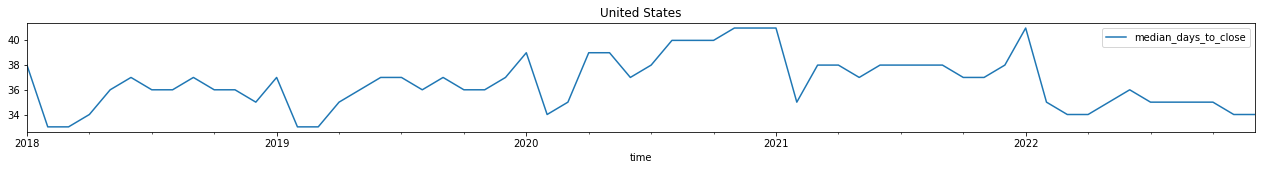

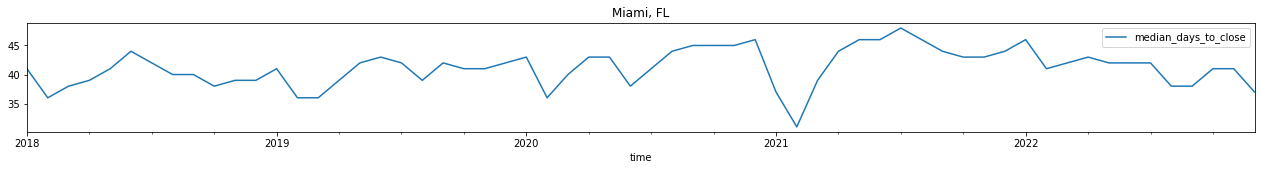

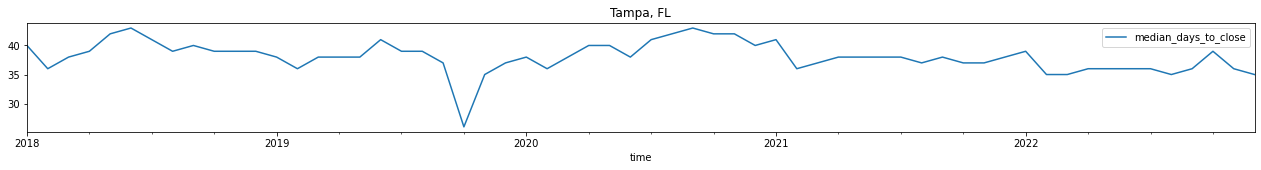

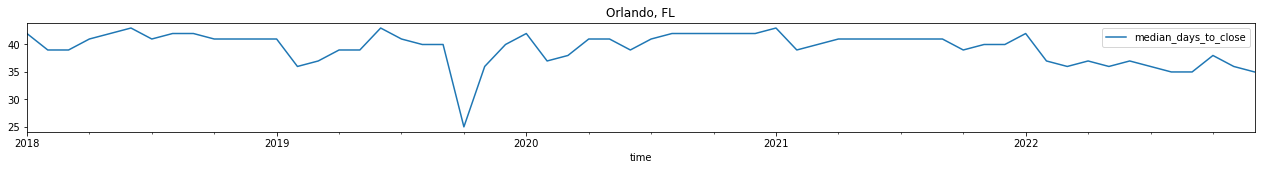

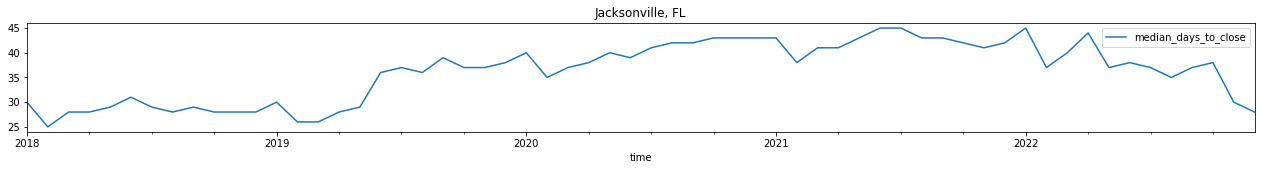

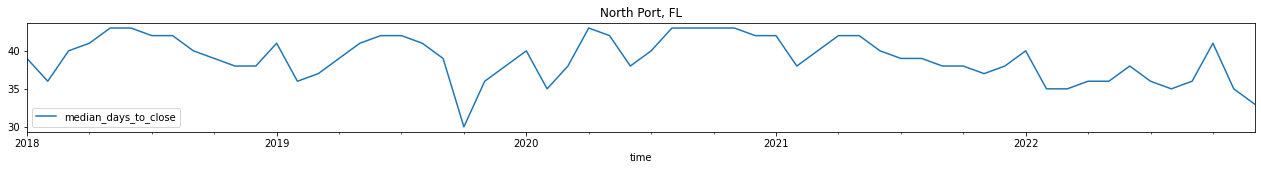

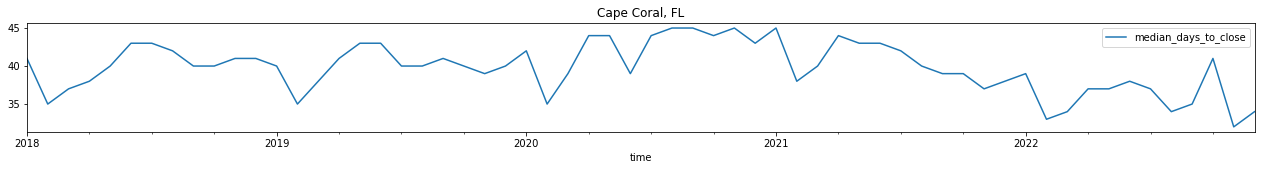

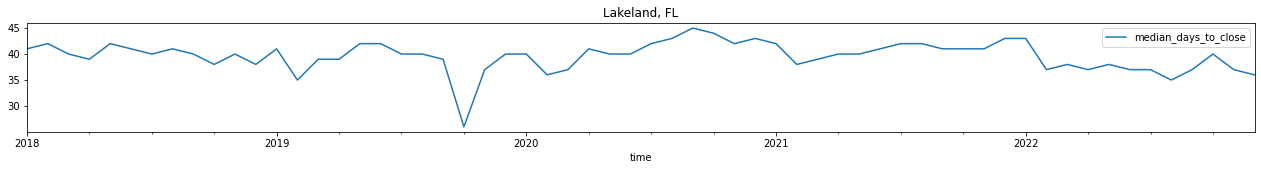

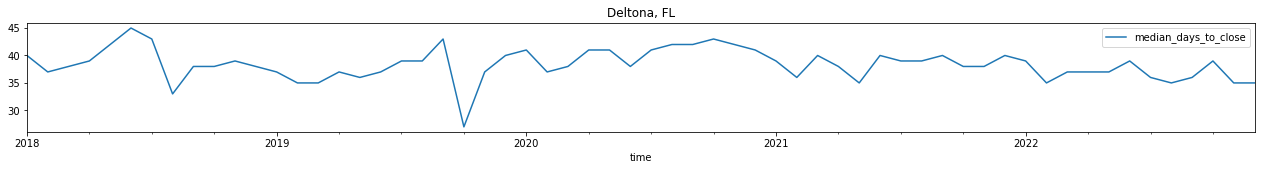

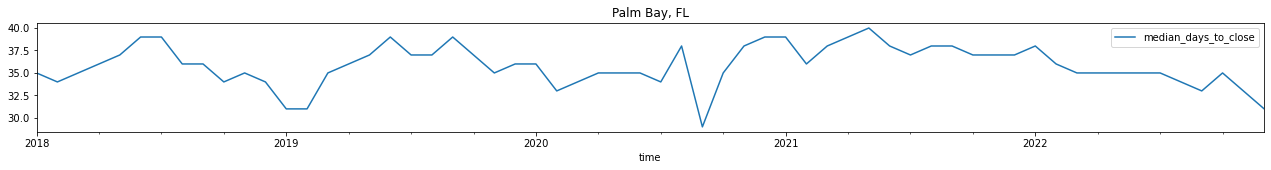

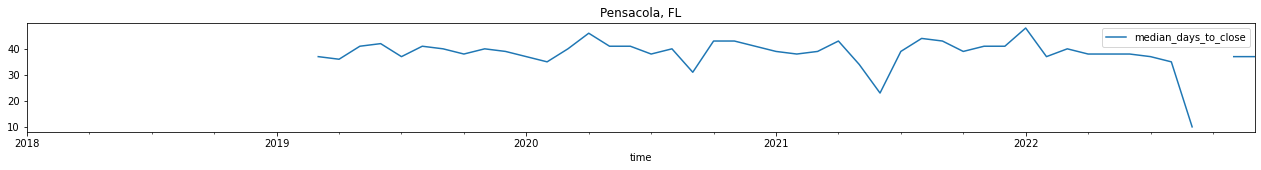

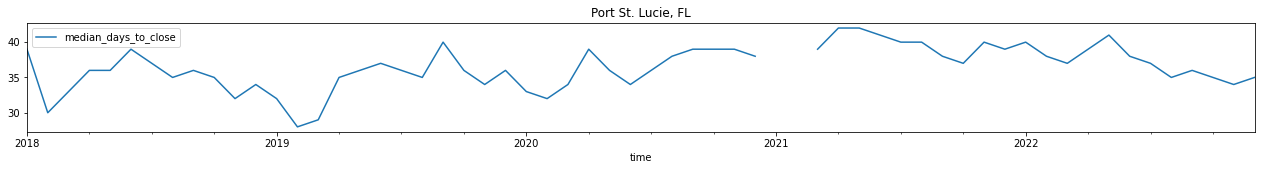

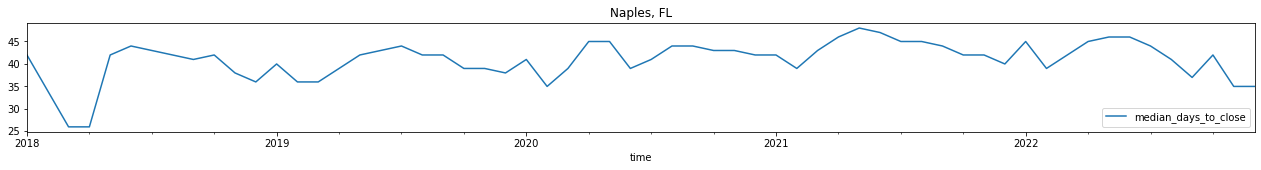

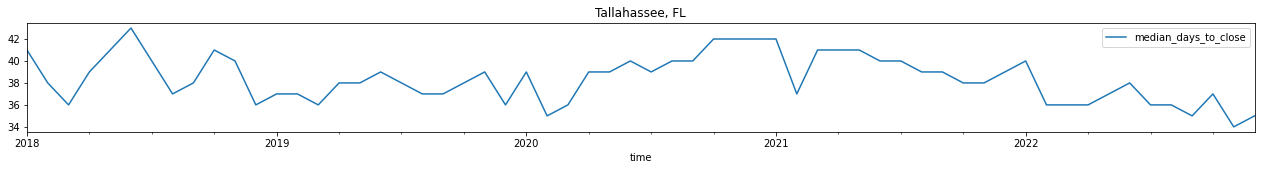

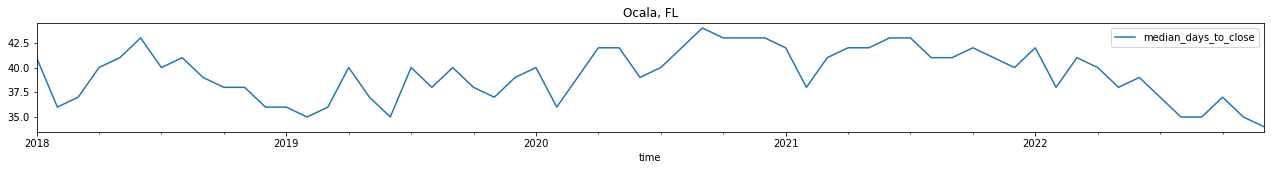

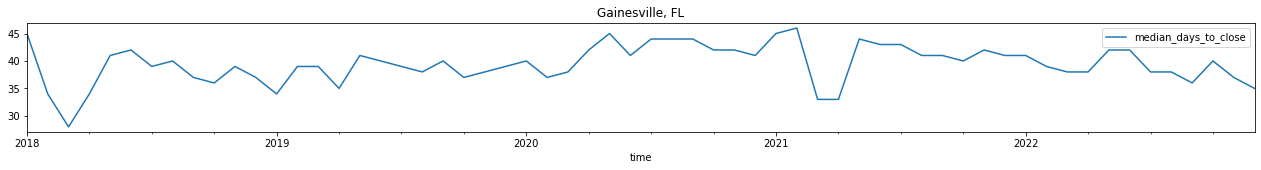

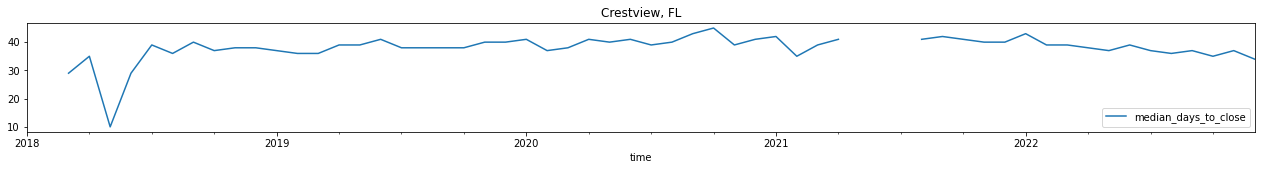

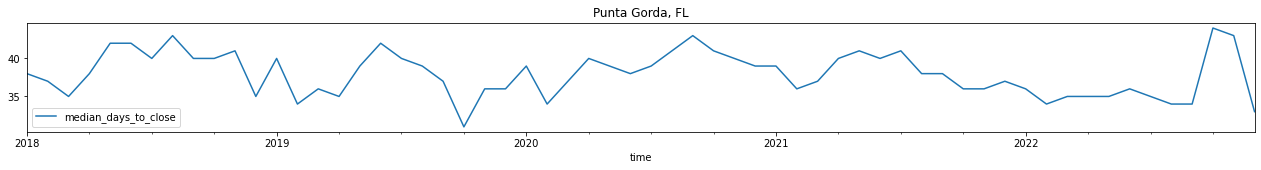

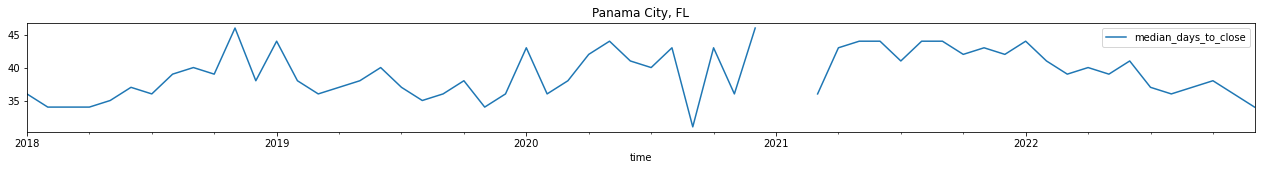

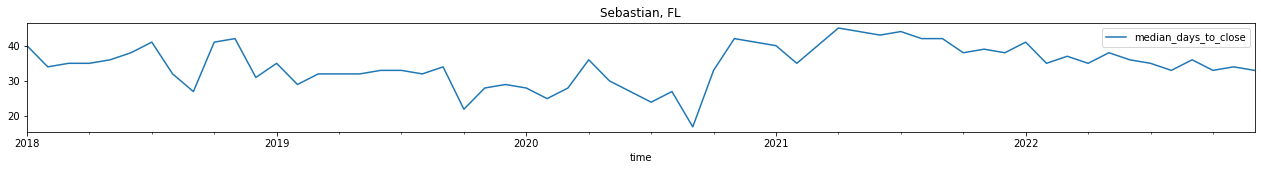

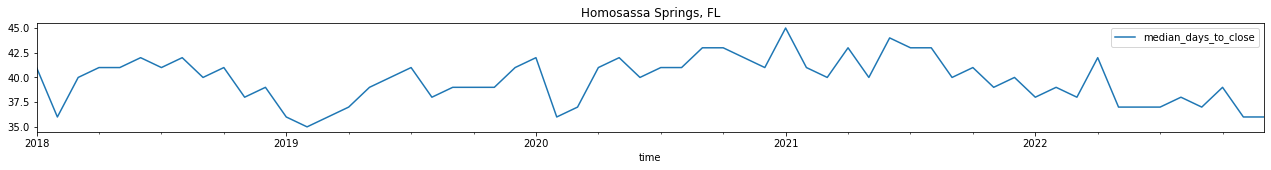

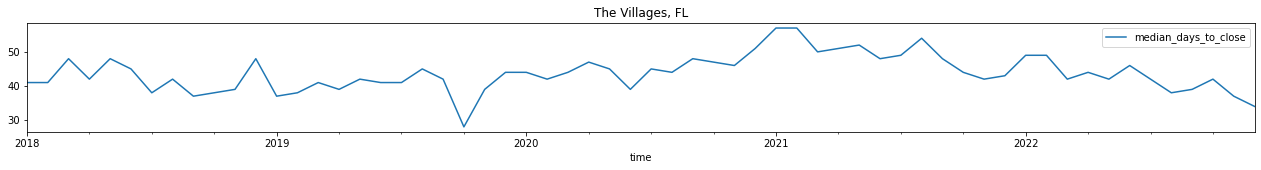

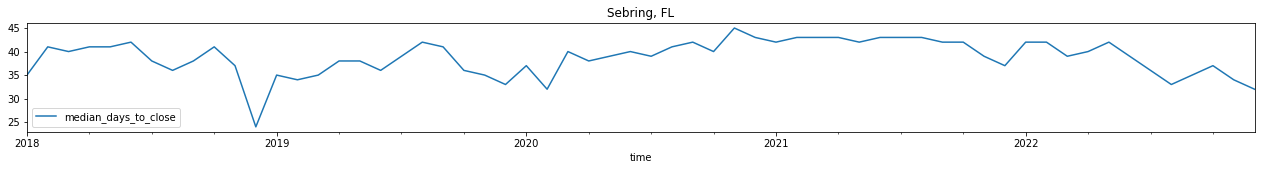

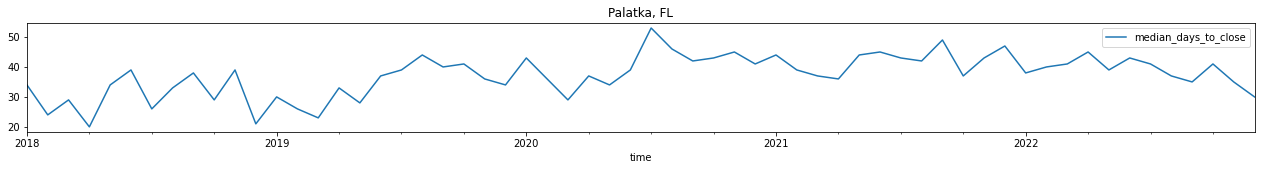

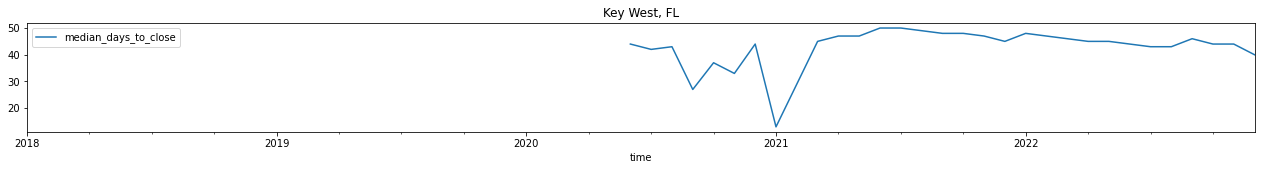

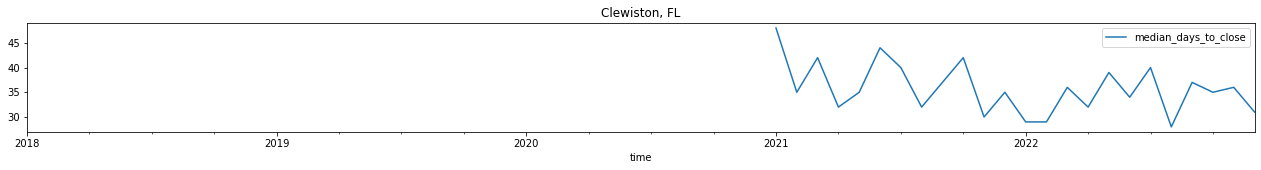

In [23]:
days_to_close_loc = []
days_to_close_ts = []
create_ts(days_to_close_loc, days_to_close_ts, id_vars, days_to_close)

## Now that we looked at the data, time to check the sale price more closely. Will use US data as a baseline before looking at florida specifically

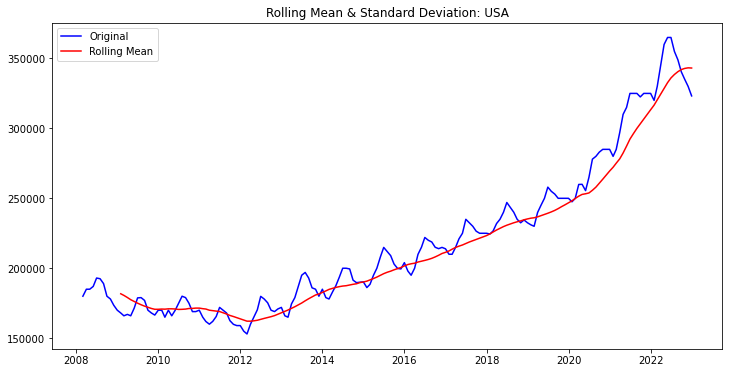

In [24]:
us_median_price = us_ts[3]

roll_mean = us_median_price.rolling(window=12, center=False).mean()
roll_std = us_median_price.rolling(window=12, center=False).std()

fig = plt.figure(figsize=(12,6))
plt.plot(us_median_price, color='blue',label='Original')
plt.plot(roll_mean, color='red', label='Rolling Mean')
# plt.plot(roll_std, color='black', label = 'Rolling Std')
plt.legend(loc='best')
plt.title('Rolling Mean & Standard Deviation: USA')
plt.show()

In [25]:
def dickey_fuller(ts):
    print ('Results of Dickey-Fuller Test: \n')
    dickey = adfuller(ts)
    results = pd.Series(dickey[0:4], index=['Test Statistic', 'p-value', '#Lags Used', 'Number of Observations Used'])
    for key,value in dickey[4].items():
        results['Critical Value (%s)'%key] = value
    print(results)

In [26]:
dickey_fuller(us_median_price)

Results of Dickey-Fuller Test: 

Test Statistic                  -0.303982
p-value                          0.924939
#Lags Used                      13.000000
Number of Observations Used    165.000000
Critical Value (1%)             -3.470616
Critical Value (5%)             -2.879221
Critical Value (10%)            -2.576197
dtype: float64


RMSE = 5069.83694028946


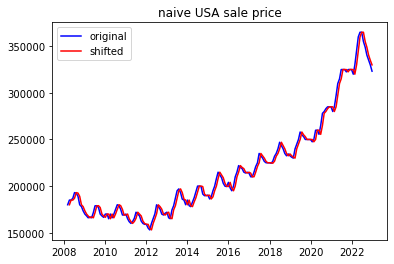

In [27]:
naive = us_median_price.shift(1)

fig, ax = plt.subplots()

ax.plot(us_median_price, c='b', label='original')
ax.plot(naive, c='r', label='shifted')
ax.set_title('naive USA sale price')
ax.legend();

print(f'RMSE = {np.sqrt(mean_squared_error(us_median_price[1:], naive.dropna()))}')

## Deal with seasonality and trend

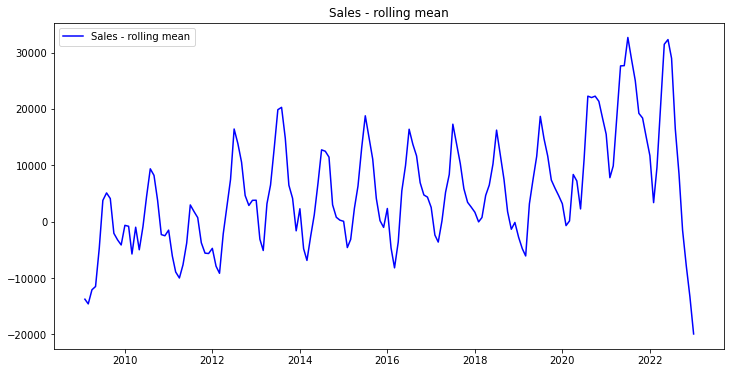

Results of Dickey-Fuller Test: 

Test Statistic                  -2.512698
p-value                          0.112415
#Lags Used                      12.000000
Number of Observations Used    155.000000
Critical Value (1%)             -3.473259
Critical Value (5%)             -2.880374
Critical Value (10%)            -2.576812
dtype: float64


In [28]:
minus_roll_mean = us_median_price - roll_mean
minus_roll_mean.dropna(inplace=True)

fig = plt.figure(figsize=(12,6))
plt.plot(minus_roll_mean, color='blue', label='Sales - rolling mean')
plt.legend(loc='best')
plt.title('Sales - rolling mean')
plt.show();
dickey_fuller(minus_roll_mean)

## log or sqrt might be better

## Exponential weighted moving average didn't help much

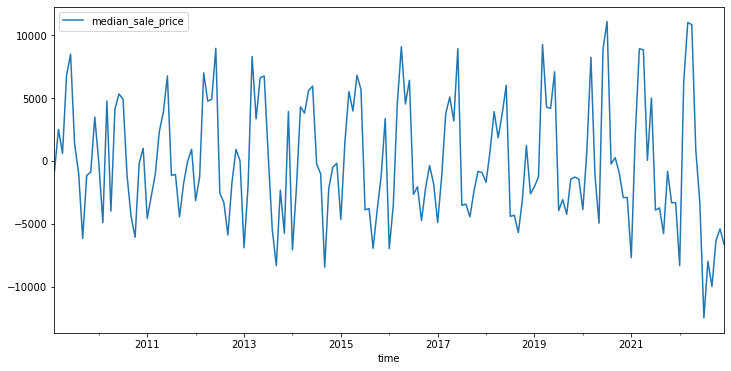

Results of Dickey-Fuller Test: 

Test Statistic                  -2.062070
p-value                          0.260037
#Lags Used                      12.000000
Number of Observations Used    154.000000
Critical Value (1%)             -3.473543
Critical Value (5%)             -2.880498
Critical Value (10%)            -2.576878
dtype: float64


In [29]:
roll_mean_diff = minus_roll_mean.diff(periods=1)
roll_mean_diff.dropna(inplace=True)
roll_mean_diff.plot(figsize=(12,6))
plt.show()
dickey_fuller(roll_mean_diff)

## The differencing has helped, but there is still some yearly seasonality. To do this more efficiently, we need SARIMAX

In [30]:
# find the index which allows us to split off 20% of the data
cutoff = round(us_median_price.shape[0]*0.8)
cutoff

143

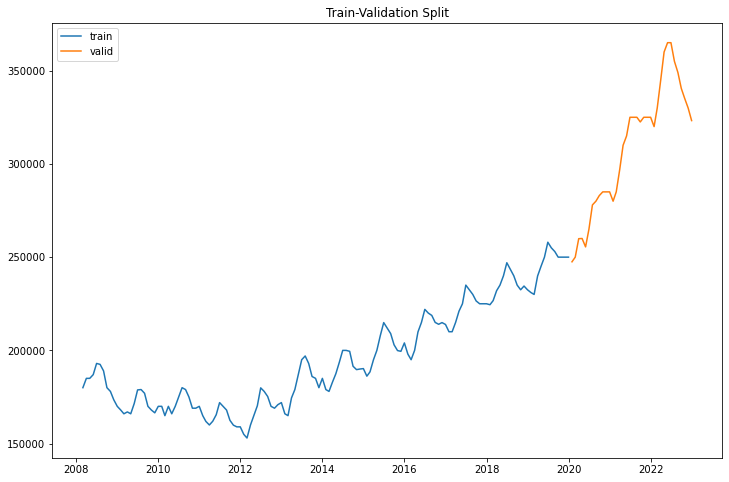

In [31]:
# Define train and test sets according to the index found above
train = us_median_price[:cutoff]

valid = us_median_price[cutoff:]

fig, ax = plt.subplots(figsize=(12,8))
ax.plot(train, label='train')
# ax.plot(valid)
ax.plot(valid, label='valid')
ax.set_title('Train-Validation Split');
plt.legend()

naive RMSE = 4407.3060900998225


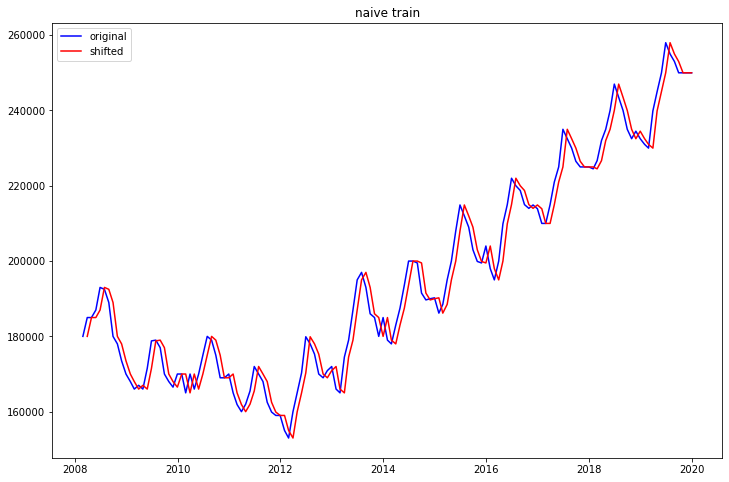

In [32]:
naive_train = train.shift(1)

fig, ax = plt.subplots(figsize=(12,8))

ax.plot(train, c='b', label='original')
ax.plot(naive_train, c='r', label='shifted')
ax.set_title('naive train')
ax.legend();

print(f'naive RMSE = {np.sqrt(mean_squared_error(train[1:], naive_train.dropna()))}')

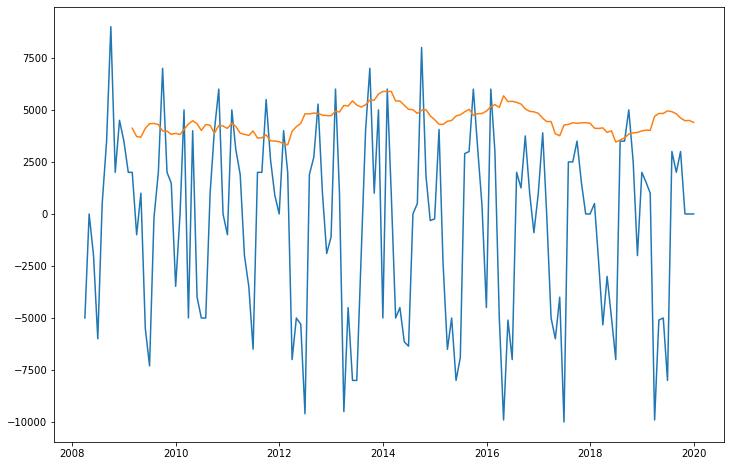

In [33]:
fig, ax = plt.subplots(figsize=(12,8))
residuals = naive_train[1:] - train[1:]
ax.plot(residuals.index, residuals)
ax.plot(residuals.index, residuals.rolling(12).std());

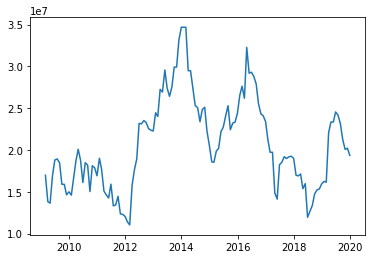

In [34]:
fig, ax = plt.subplots()

ax.plot(residuals.index, residuals.rolling(12).var());

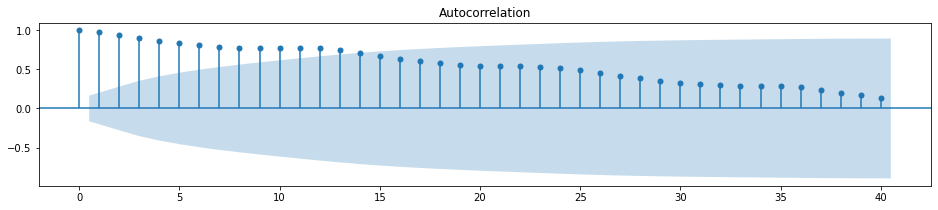

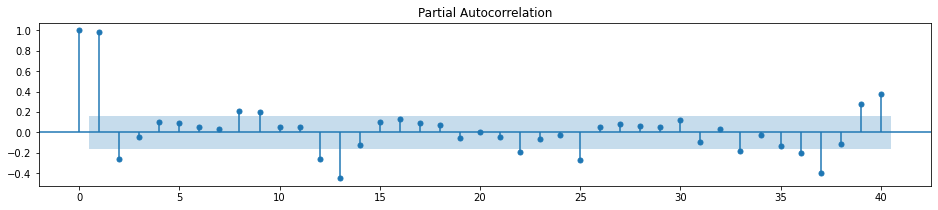

In [35]:
fig, ax = plt.subplots(figsize=(16,3))
plot_acf(train, ax=ax, lags=40);

fig, ax = plt.subplots(figsize=(16,3))
plot_pacf(train, ax=ax, lags=40);

In [36]:
# Define the p, d and q parameters to take any value between 0 and 2
p = d = q = range(0, 3)

# Generate all different combinations of p, q and q triplets
pdq = list(itertools.product(p, d, q))

# Generate all different combinations of seasonal p, q and q triplets
pdqs = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]

In [37]:
# Run a grid with pdq and seasonal pdq parameters calculated above and get the best AIC value
ans = []
for comb in pdq:
    for combs in pdqs:
        try:
            mod = sm.tsa.statespace.SARIMAX(train,
                                            order=comb,
                                            seasonal_order=combs,
                                            enforce_stationarity=False,
                                            enforce_invertibility=False)

            output = mod.fit()
            ans.append([comb, combs, output.aic])
            print('ARIMA {} x {}: AIC Calculated={}'.format(comb, combs, output.aic))
        except:
            continue

ARIMA (0, 0, 0) x (0, 0, 0, 12): AIC Calculated=3868.4648359643375
ARIMA (0, 0, 0) x (0, 0, 1, 12): AIC Calculated=397927.20423876063
ARIMA (0, 0, 0) x (0, 0, 2, 12): AIC Calculated=3143.023809096115
ARIMA (0, 0, 0) x (0, 1, 0, 12): AIC Calculated=2785.997609477893
ARIMA (0, 0, 0) x (0, 1, 1, 12): AIC Calculated=2518.3466983928965
ARIMA (0, 0, 0) x (0, 1, 2, 12): AIC Calculated=2239.1159129949906
ARIMA (0, 0, 0) x (0, 2, 0, 12): AIC Calculated=2496.8888558204135
ARIMA (0, 0, 0) x (0, 2, 1, 12): AIC Calculated=2228.1731746254463
ARIMA (0, 0, 0) x (0, 2, 2, 12): AIC Calculated=1858.683980604495
ARIMA (0, 0, 0) x (1, 0, 0, 12): AIC Calculated=2754.819778401922
ARIMA (0, 0, 0) x (1, 0, 1, 12): AIC Calculated=2680.4955884393958
ARIMA (0, 0, 0) x (1, 0, 2, 12): AIC Calculated=2610.220384706946
ARIMA (0, 0, 0) x (1, 1, 0, 12): AIC Calculated=2494.257320518133
ARIMA (0, 0, 0) x (1, 1, 1, 12): AIC Calculated=2464.6957334893464
ARIMA (0, 0, 0) x (1, 1, 2, 12): AIC Calculated=2230.8593844459606
A

ARIMA (0, 1, 1) x (1, 2, 1, 12): AIC Calculated=1991.8450464417726
ARIMA (0, 1, 1) x (1, 2, 2, 12): AIC Calculated=1759.3439724303607
ARIMA (0, 1, 1) x (2, 0, 0, 12): AIC Calculated=2182.512441872473
ARIMA (0, 1, 1) x (2, 0, 1, 12): AIC Calculated=2183.7528893333174
ARIMA (0, 1, 1) x (2, 0, 2, 12): AIC Calculated=2148.1199093399014
ARIMA (0, 1, 1) x (2, 1, 0, 12): AIC Calculated=1955.5960600744797
ARIMA (0, 1, 1) x (2, 1, 1, 12): AIC Calculated=1957.1553761999587
ARIMA (0, 1, 1) x (2, 1, 2, 12): AIC Calculated=1918.7351843980755
ARIMA (0, 1, 1) x (2, 2, 0, 12): AIC Calculated=1774.1280088378
ARIMA (0, 1, 1) x (2, 2, 1, 12): AIC Calculated=1775.6334293251746
ARIMA (0, 1, 1) x (2, 2, 2, 12): AIC Calculated=1760.017729893061
ARIMA (0, 1, 2) x (0, 0, 0, 12): AIC Calculated=2707.653916791337
ARIMA (0, 1, 2) x (0, 0, 1, 12): AIC Calculated=2440.4886431601235
ARIMA (0, 1, 2) x (0, 0, 2, 12): AIC Calculated=2179.5196146992107
ARIMA (0, 1, 2) x (0, 1, 0, 12): AIC Calculated=2380.0105806943593
A

ARIMA (1, 0, 0) x (0, 1, 2, 12): AIC Calculated=1956.2394452448893
ARIMA (1, 0, 0) x (0, 2, 0, 12): AIC Calculated=2329.9896102364673
ARIMA (1, 0, 0) x (0, 2, 1, 12): AIC Calculated=2040.8864210178535
ARIMA (1, 0, 0) x (0, 2, 2, 12): AIC Calculated=1795.661350097041
ARIMA (1, 0, 0) x (1, 0, 0, 12): AIC Calculated=2472.5799256993423
ARIMA (1, 0, 0) x (1, 0, 1, 12): AIC Calculated=2474.4619818314086
ARIMA (1, 0, 0) x (1, 0, 2, 12): AIC Calculated=2243.315630964722
ARIMA (1, 0, 0) x (1, 1, 0, 12): AIC Calculated=2188.2120021002243
ARIMA (1, 0, 0) x (1, 1, 1, 12): AIC Calculated=2190.1540853874303
ARIMA (1, 0, 0) x (1, 1, 2, 12): AIC Calculated=1958.223815170849
ARIMA (1, 0, 0) x (1, 2, 0, 12): AIC Calculated=2039.5472257739139
ARIMA (1, 0, 0) x (1, 2, 1, 12): AIC Calculated=2054.0013034061562
ARIMA (1, 0, 0) x (1, 2, 2, 12): AIC Calculated=1803.32285850494
ARIMA (1, 0, 0) x (2, 0, 0, 12): AIC Calculated=2240.1663099171437
ARIMA (1, 0, 0) x (2, 0, 1, 12): AIC Calculated=2184.96920470915
AR

ARIMA (1, 1, 1) x (2, 1, 0, 12): AIC Calculated=1937.007932927284
ARIMA (1, 1, 1) x (2, 1, 1, 12): AIC Calculated=1938.813963008452
ARIMA (1, 1, 1) x (2, 1, 2, 12): AIC Calculated=1918.4125522473933
ARIMA (1, 1, 1) x (2, 2, 0, 12): AIC Calculated=1752.4445542189956
ARIMA (1, 1, 1) x (2, 2, 1, 12): AIC Calculated=1754.9219620936087
ARIMA (1, 1, 1) x (2, 2, 2, 12): AIC Calculated=1763.1873115452177
ARIMA (1, 1, 2) x (0, 0, 0, 12): AIC Calculated=2708.7896722653145
ARIMA (1, 1, 2) x (0, 0, 1, 12): AIC Calculated=2435.295487090926
ARIMA (1, 1, 2) x (0, 0, 2, 12): AIC Calculated=2192.3898262272337
ARIMA (1, 1, 2) x (0, 1, 0, 12): AIC Calculated=2381.93282137199
ARIMA (1, 1, 2) x (0, 1, 1, 12): AIC Calculated=2141.306885762885
ARIMA (1, 1, 2) x (0, 1, 2, 12): AIC Calculated=1902.745018742262
ARIMA (1, 1, 2) x (0, 2, 0, 12): AIC Calculated=2278.9787602503393
ARIMA (1, 1, 2) x (0, 2, 1, 12): AIC Calculated=1949.2194848585498
ARIMA (1, 1, 2) x (0, 2, 2, 12): AIC Calculated=1744.2665424725176
AR

ARIMA (2, 0, 0) x (1, 0, 1, 12): AIC Calculated=2443.9181076966424
ARIMA (2, 0, 0) x (1, 0, 2, 12): AIC Calculated=2231.609015421725
ARIMA (2, 0, 0) x (1, 1, 0, 12): AIC Calculated=2170.9587840083714
ARIMA (2, 0, 0) x (1, 1, 1, 12): AIC Calculated=2172.71000724655
ARIMA (2, 0, 0) x (1, 1, 2, 12): AIC Calculated=1959.4172638435264
ARIMA (2, 0, 0) x (1, 2, 0, 12): AIC Calculated=2032.2372283270956
ARIMA (2, 0, 0) x (1, 2, 1, 12): AIC Calculated=2033.9258053299902
ARIMA (2, 0, 0) x (1, 2, 2, 12): AIC Calculated=1802.7771725402433
ARIMA (2, 0, 0) x (2, 0, 0, 12): AIC Calculated=2209.790812752022
ARIMA (2, 0, 0) x (2, 0, 1, 12): AIC Calculated=2211.749863677505
ARIMA (2, 0, 0) x (2, 0, 2, 12): AIC Calculated=2213.3640051264783
ARIMA (2, 0, 0) x (2, 1, 0, 12): AIC Calculated=1936.888735470534
ARIMA (2, 0, 0) x (2, 1, 1, 12): AIC Calculated=1938.501309970785
ARIMA (2, 0, 0) x (2, 1, 2, 12): AIC Calculated=1940.2888209460766
ARIMA (2, 0, 0) x (2, 2, 0, 12): AIC Calculated=1782.417197490643
ARI

ARIMA (2, 1, 1) x (2, 2, 2, 12): AIC Calculated=1763.6721375129405
ARIMA (2, 1, 2) x (0, 0, 0, 12): AIC Calculated=2691.512069457054
ARIMA (2, 1, 2) x (0, 0, 1, 12): AIC Calculated=2436.3003951406668
ARIMA (2, 1, 2) x (0, 0, 2, 12): AIC Calculated=2193.2846418040003
ARIMA (2, 1, 2) x (0, 1, 0, 12): AIC Calculated=2379.917430239553
ARIMA (2, 1, 2) x (0, 1, 1, 12): AIC Calculated=2142.8360810208906
ARIMA (2, 1, 2) x (0, 1, 2, 12): AIC Calculated=1901.27052908926
ARIMA (2, 1, 2) x (0, 2, 0, 12): AIC Calculated=2275.308231212426
ARIMA (2, 1, 2) x (0, 2, 1, 12): AIC Calculated=1987.4158839811525
ARIMA (2, 1, 2) x (0, 2, 2, 12): AIC Calculated=1746.1549695312938
ARIMA (2, 1, 2) x (1, 0, 0, 12): AIC Calculated=2393.8543854987893
ARIMA (2, 1, 2) x (1, 0, 1, 12): AIC Calculated=2405.618317224548
ARIMA (2, 1, 2) x (1, 0, 2, 12): AIC Calculated=2172.2346578384772
ARIMA (2, 1, 2) x (1, 1, 0, 12): AIC Calculated=2148.636271145479
ARIMA (2, 1, 2) x (1, 1, 1, 12): AIC Calculated=2130.5320839583587
AR

In [38]:
# Find the parameters with minimal AIC value
ans_df = pd.DataFrame(ans, columns=['pdq', 'pdqs', 'aic'])
ans_df.loc[ans_df['aic'].idxmin()]

pdq         (1, 1, 0)
pdqs    (2, 2, 1, 12)
aic           1718.76
Name: 349, dtype: object

In [39]:
ans_df.sort_values('aic').head(20)

pdq           pdqs          aic
349  (1, 1, 0)  (2, 2, 1, 12)  1718.761322
107  (0, 1, 0)  (2, 2, 2, 12)  1719.007467
646  (2, 1, 2)  (2, 2, 1, 12)  1721.332997
98   (0, 1, 0)  (1, 2, 2, 12)  1724.780550
591  (2, 1, 0)  (2, 2, 0, 12)  1731.420958
645  (2, 1, 2)  (2, 2, 0, 12)  1732.681328
592  (2, 1, 0)  (2, 2, 1, 12)  1733.016680
618  (2, 1, 1)  (2, 2, 0, 12)  1733.445436
619  (2, 1, 1)  (2, 2, 1, 12)  1736.202001
143  (0, 1, 2)  (0, 2, 2, 12)  1742.534225
152  (0, 1, 2)  (1, 2, 2, 12)  1744.120562
386  (1, 1, 2)  (0, 2, 2, 12)  1744.266542
161  (0, 1, 2)  (2, 2, 2, 12)  1744.843107
89   (0, 1, 0)  (0, 2, 2, 12)  1745.616146
395  (1, 1, 2)  (1, 2, 2, 12)  1745.850715
629  (2, 1, 2)  (0, 2, 2, 12)  1746.154970
449  (1, 2, 1)  (1, 2, 2, 12)  1746.965020
404  (1, 1, 2)  (2, 2, 2, 12)  1747.088942
672  (2, 2, 0)  (2, 2, 0, 12)  1747.280261
593  (2, 1, 0)  (2, 2, 2, 12)  1747.471892

In [40]:
# Plug the optimal parameter values into a new SARIMAX model
ARIMA_MODEL = sm.tsa.statespace.SARIMAX(train, 
                                        order=(1,1,0), 
                                        seasonal_order=(2,2,1,12), 
                                        enforce_stationarity=False, 
                                        enforce_invertibility=False)

# Fit the model and print results
output = ARIMA_MODEL.fit()

print(output.summary())

                                      SARIMAX Results                                       
Dep. Variable:                    median_sale_price   No. Observations:                  143
Model:             SARIMAX(1, 1, 0)x(2, 2, [1], 12)   Log Likelihood                -854.381
Date:                              Thu, 02 Mar 2023   AIC                           1718.761
Time:                                      10:52:20   BIC                           1731.424
Sample:                                  02-29-2008   HQIC                          1723.874
                                       - 12-31-2019                                         
Covariance Type:                                opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0049      0.060      0.081      0.935      -0.114       0.123
ar.S.L12      -0.42

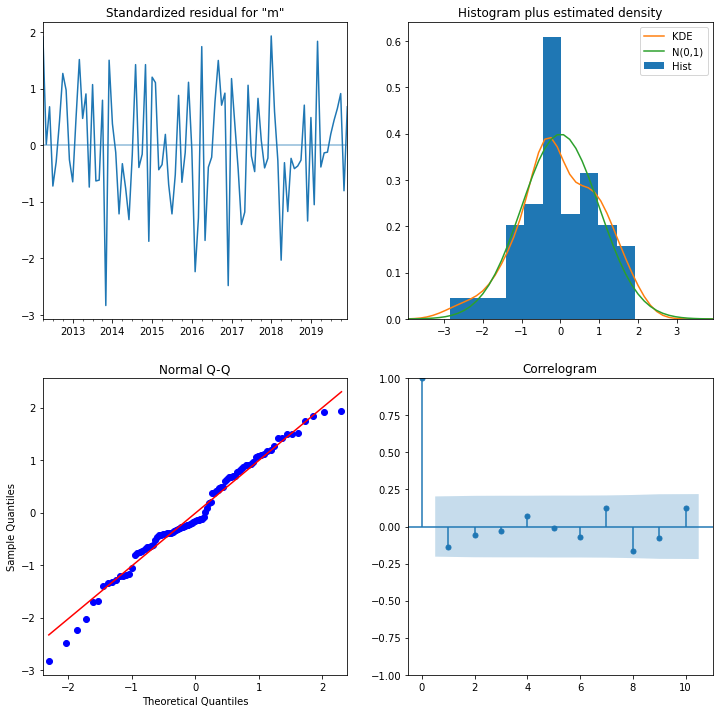

In [41]:
output.plot_diagnostics(figsize=(12, 12))
plt.show()

In [42]:
pred = output.get_prediction(start=pd.to_datetime('2017-01-31'), dynamic=False) #change start to validate dataset
pred_conf = pred.conf_int()

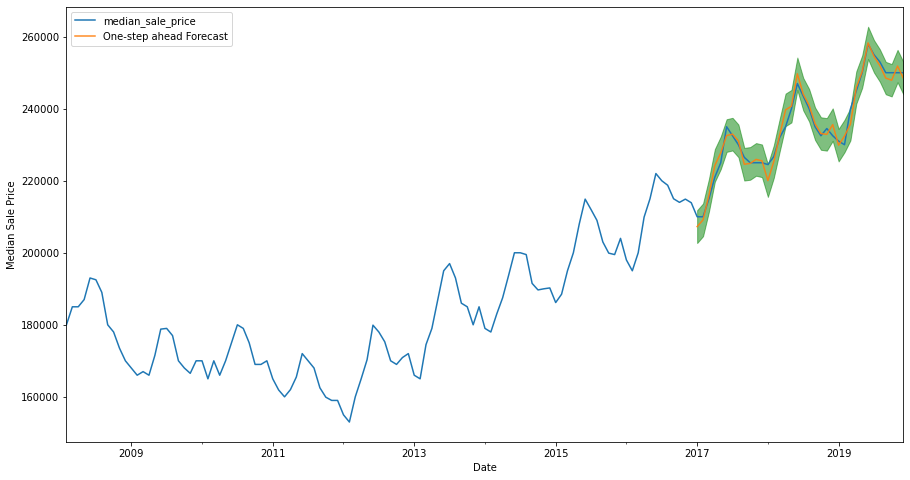

In [43]:
rcParams['figure.figsize'] = 15, 8

# Plot observed values
ax = train.plot(label='observed')

# Plot predicted values
pred.predicted_mean.plot(ax=ax, label='One-step ahead Forecast', alpha=0.9)

# Plot the range for confidence intervals
ax.fill_between(pred_conf.index.values,
                pred_conf.iloc[:, 0],
                pred_conf.iloc[:, 1], color='g', alpha=0.5)

# Set axes labels
ax.set_xlabel('Date')
ax.set_ylabel('Median Sale Price')
plt.legend()

plt.show()

## As expected, its pretty accurate, but how about when forecasting on the validation set

In [44]:
# Get forecast 500 steps ahead in future
prediction = output.get_forecast(steps=36)

# Get confidence intervals of forecasts
pred_conf = prediction.conf_int()

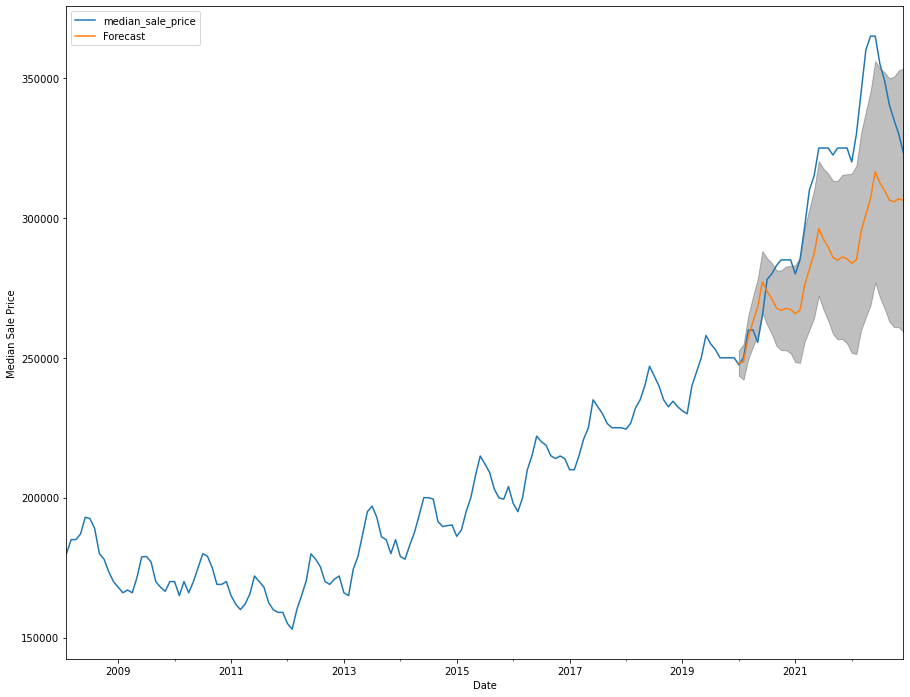

In [45]:
ax = us_median_price.plot(label='observed', figsize=(15, 12))

prediction.predicted_mean.plot(ax=ax, label='Model Prediction')

ax.fill_between(pred_conf.index,
                pred_conf.iloc[:, 0],
                pred_conf.iloc[:, 1], color='k', alpha=0.25)

ax.set_xlabel('Date')
ax.set_ylabel('Median Sale Price')

plt.legend()
plt.show()

In [46]:
# Get the real and predicted values
sp_forecasted = prediction.predicted_mean
sp_truth = valid
sp_truth['forecast'] = sp_forecasted

# # Compute the mean square error
rmse = np.sqrt(((sp_truth['median_sale_price'] - sp_truth['forecast']) ** 2).mean())
print('Root Mean Squared Error of forecasts is {}'.format(round(rmse, 2)))

Root Mean Squared Error of forecasts is 30945.05


In [47]:
# Get forecast 500 steps ahead in future
forecast = output.get_forecast(steps=72)

# Get confidence intervals of forecasts
forecast_conf = prediction.conf_int()

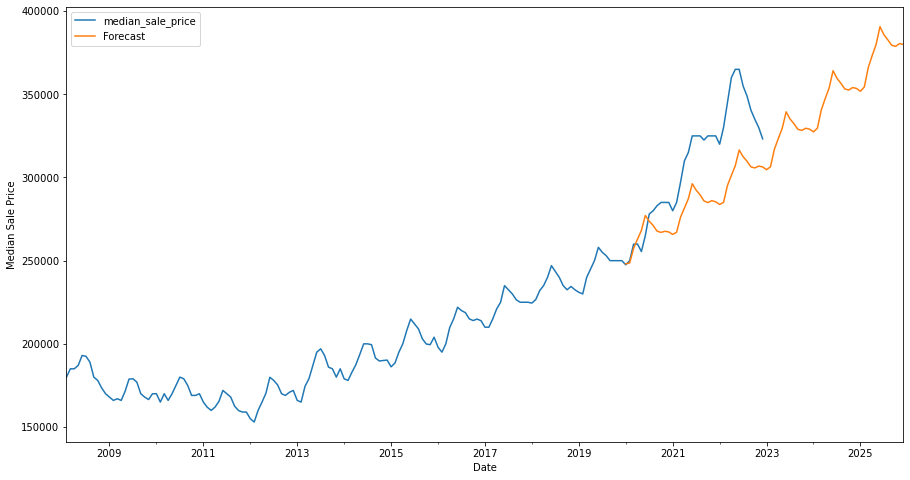

In [51]:
ax = us_median_price.plot(label='observed', figsize=(15, 8))

forecast.predicted_mean.plot(ax=ax, label='Forecast')

ax.set_xlabel('Date')
ax.set_ylabel('Median Sale Price')

plt.legend()
plt.show()

## unsurprisingly, the model fails to capture the accelerated rise in prices. How can we help account for this?

In [ ]:
us_ts[1].plot(figsize=(22,2));
us_ts[-2].plot(figsize=(22,2));

## Unfortunately we don't have data from before 2018, but assuming that the period from 2012-2020 remains relatively unchanged, the deviations from 2020 onward might account for the price change.

## Days pending Work

In [ ]:
# dickey_fuller(us_ts[1]['2018-01-31':'2020-01-31'])

In [ ]:
# base_days_pending = us_ts[1]['2018-01-31':'2020-01-31']

In [ ]:
# # Run a grid with pdq and seasonal pdq parameters calculated above and get the best AIC value
# ans = []
# for comb in pdq:
#     for combs in pdqs:
#         try:
#             mod = sm.tsa.statespace.SARIMAX(base_days_pending,
#                                             order=comb,
#                                             seasonal_order=combs,
#                                             enforce_stationarity=False,
#                                             enforce_invertibility=False)

#             output = mod.fit()
#             ans.append([comb, combs, output.aic])
#             print('ARIMA {} x {}: AIC Calculated={}'.format(comb, combs, output.aic))
#         except:
#             continue

In [ ]:
# ans_df = pd.DataFrame(ans, columns=['pdq', 'pdqs', 'aic'])
# ans_df.loc[ans_df['aic'].idxmin()]

In [ ]:
# ans_df.sort_values('aic').head()

In [ ]:
# # Plug the optimal parameter values into a new SARIMAX model
# ARIMA_MODEL = sm.tsa.statespace.SARIMAX(base_days_pending, 
#                                         order=(0,0,0), 
#                                         seasonal_order=(1,1,0,12), 
#                                         enforce_stationarity=True, 
#                                         enforce_invertibility=False)

# # Fit the model and print results
# output = ARIMA_MODEL.fit()

# print(output.summary())

In [ ]:
# prediction = output.get_forecast(steps=36)
# pred_conf = prediction.conf_int()

In [ ]:
# ax = us_ts[1].plot(label='observed', figsize=(15, 8))

# prediction.predicted_mean.plot(ax=ax, label='Forecast')

# ax.fill_between(pred_conf.index,
#                 pred_conf.iloc[:, 0],
#                 pred_conf.iloc[:, 1], color='k', alpha=0.25)

# ax.set_xlabel('Date')
# ax.set_ylabel('Days Pending')

# plt.legend()
# plt.show()

In [ ]:
# prediction.predicted_mean.head()

In [ ]:
# days_pending_res = us_ts[1]
# days_preds = prediction.predicted_mean.to_frame()
# days_pending_res = pd.concat([days_pending_res, days_preds], axis=1).dropna()
# days_pending_res['residuals'] = days_pending_res['predicted_mean'] - days_pending_res['median_days_pending']

In [ ]:
# days_pending_res.head()

In [67]:
# sp_truth['residuals'].corr(days_pending_res['residuals'])

In [ ]:
# days_pending_res['residuals'].plot()

## Sale to Price Ratio Work

<AxesSubplot:xlabel='time'>

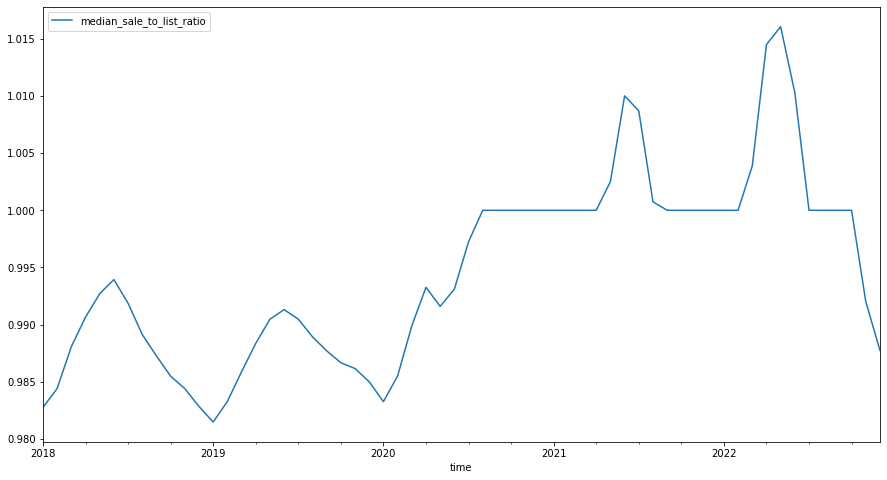

In [52]:
base_sale_to_list = us_ts[-2]
base_sale_to_list.plot()

In [53]:
base_sale_to_list = base_sale_to_list['2018-01-31':'2020-01-31']

In [54]:
ans = []
for comb in pdq:
    for combs in pdqs:
        try:
            mod = sm.tsa.statespace.SARIMAX(base_sale_to_list,
                                            order=comb,
                                            seasonal_order=combs,
                                            enforce_stationarity=True,
                                            enforce_invertibility=False)

            output = mod.fit()
            ans.append([comb, combs, output.aic])
            print('ARIMA {} x {}: AIC Calculated={}'.format(comb, combs, output.aic))
        except:
            continue

ARIMA (0, 0, 0) x (0, 0, 0, 12): AIC Calculated=72.30822083461705
ARIMA (0, 0, 0) x (0, 0, 1, 12): AIC Calculated=60.31706833177491
ARIMA (0, 0, 0) x (0, 0, 2, 12): AIC Calculated=53.522215181491724
ARIMA (0, 0, 0) x (0, 1, 0, 12): AIC Calculated=-126.32379728546661
ARIMA (0, 0, 0) x (0, 1, 1, 12): AIC Calculated=-124.3239379147789
ARIMA (0, 0, 0) x (0, 1, 2, 12): AIC Calculated=-122.32382337848557
ARIMA (0, 0, 0) x (0, 2, 0, 12): AIC Calculated=-6.7412855513968
ARIMA (0, 0, 0) x (1, 0, 0, 12): AIC Calculated=-53.358448429288934
ARIMA (0, 0, 0) x (1, 0, 1, 12): AIC Calculated=-53.19318470978895
ARIMA (0, 0, 0) x (1, 0, 2, 12): AIC Calculated=-50.23567857473797
ARIMA (0, 0, 0) x (1, 1, 0, 12): AIC Calculated=-124.32393797287227
ARIMA (0, 0, 0) x (1, 1, 1, 12): AIC Calculated=-122.32393826934032
ARIMA (0, 0, 0) x (1, 1, 2, 12): AIC Calculated=-120.32382395979653
ARIMA (0, 0, 0) x (2, 0, 0, 12): AIC Calculated=-32.81069397845708
ARIMA (0, 0, 0) x (2, 0, 1, 12): AIC Calculated=-66.62407084

ARIMA (0, 1, 2) x (2, 1, 0, 12): AIC Calculated=-131.63822520329046
ARIMA (0, 1, 2) x (2, 1, 1, 12): AIC Calculated=-129.63784787712126
ARIMA (0, 1, 2) x (2, 1, 2, 12): AIC Calculated=-127.6371994352929
ARIMA (0, 1, 2) x (2, 2, 0, 12): AIC Calculated=10.0
ARIMA (0, 1, 2) x (2, 2, 1, 12): AIC Calculated=12.0
ARIMA (0, 1, 2) x (2, 2, 2, 12): AIC Calculated=14.0
ARIMA (0, 2, 0) x (0, 0, 0, 12): AIC Calculated=-240.2429966016599
ARIMA (0, 2, 0) x (0, 0, 1, 12): AIC Calculated=-238.24281422225235
ARIMA (0, 2, 0) x (0, 0, 2, 12): AIC Calculated=-236.2426417625424
ARIMA (0, 2, 0) x (0, 1, 0, 12): AIC Calculated=-125.01375338622063
ARIMA (0, 2, 0) x (0, 1, 1, 12): AIC Calculated=-123.01719332461799
ARIMA (0, 2, 0) x (0, 1, 2, 12): AIC Calculated=-121.01083599413869
ARIMA (0, 2, 0) x (0, 2, 0, 12): AIC Calculated=2.0
ARIMA (0, 2, 0) x (0, 2, 1, 12): AIC Calculated=4.0
ARIMA (0, 2, 0) x (0, 2, 2, 12): AIC Calculated=6.0
ARIMA (0, 2, 0) x (1, 0, 0, 12): AIC Calculated=-244.71156807310254
ARIMA (0

ARIMA (1, 0, 2) x (1, 0, 1, 12): AIC Calculated=-240.05780209718205
ARIMA (1, 0, 2) x (1, 0, 2, 12): AIC Calculated=-244.6259833317822
ARIMA (1, 0, 2) x (1, 1, 0, 12): AIC Calculated=-134.33375397395832
ARIMA (1, 0, 2) x (1, 1, 1, 12): AIC Calculated=-132.33405684548472
ARIMA (1, 0, 2) x (1, 1, 2, 12): AIC Calculated=-130.33430778990757
ARIMA (1, 0, 2) x (2, 0, 0, 12): AIC Calculated=-254.77681458668576
ARIMA (1, 0, 2) x (2, 0, 1, 12): AIC Calculated=-241.45960499401386
ARIMA (1, 0, 2) x (2, 0, 2, 12): AIC Calculated=-248.58748918909197
ARIMA (1, 0, 2) x (2, 1, 0, 12): AIC Calculated=-132.33428118052746
ARIMA (1, 0, 2) x (2, 1, 1, 12): AIC Calculated=-130.33292416850836
ARIMA (1, 0, 2) x (2, 1, 2, 12): AIC Calculated=-128.33551865419986
ARIMA (1, 1, 0) x (0, 0, 0, 12): AIC Calculated=-250.8400029565392
ARIMA (1, 1, 0) x (0, 0, 1, 12): AIC Calculated=-248.8400490997014
ARIMA (1, 1, 0) x (0, 0, 2, 12): AIC Calculated=-246.8400653291729
ARIMA (1, 1, 0) x (0, 1, 0, 12): AIC Calculated=-138

ARIMA (1, 2, 2) x (0, 0, 0, 12): AIC Calculated=-240.40186976306762
ARIMA (1, 2, 2) x (0, 0, 1, 12): AIC Calculated=-238.4011024916992
ARIMA (1, 2, 2) x (0, 0, 2, 12): AIC Calculated=-236.40140783173084
ARIMA (1, 2, 2) x (0, 1, 0, 12): AIC Calculated=-119.01184909252613
ARIMA (1, 2, 2) x (0, 1, 1, 12): AIC Calculated=-117.00374974867816
ARIMA (1, 2, 2) x (0, 1, 2, 12): AIC Calculated=-115.00600149620388
ARIMA (1, 2, 2) x (0, 2, 0, 12): AIC Calculated=8.0
ARIMA (1, 2, 2) x (0, 2, 1, 12): AIC Calculated=10.0
ARIMA (1, 2, 2) x (0, 2, 2, 12): AIC Calculated=12.0
ARIMA (1, 2, 2) x (1, 0, 0, 12): AIC Calculated=-243.34285799252842
ARIMA (1, 2, 2) x (1, 0, 1, 12): AIC Calculated=-236.4020266188648
ARIMA (1, 2, 2) x (1, 0, 2, 12): AIC Calculated=-234.40147931042696
ARIMA (1, 2, 2) x (1, 1, 0, 12): AIC Calculated=-117.01012551172224
ARIMA (1, 2, 2) x (1, 1, 1, 12): AIC Calculated=-115.0017289950501
ARIMA (1, 2, 2) x (1, 1, 2, 12): AIC Calculated=-113.00254713902532
ARIMA (1, 2, 2) x (1, 2, 0, 1

ARIMA (2, 1, 2) x (0, 0, 0, 12): AIC Calculated=-254.78873458214395
ARIMA (2, 1, 2) x (0, 0, 1, 12): AIC Calculated=-252.78875046071397
ARIMA (2, 1, 2) x (0, 0, 2, 12): AIC Calculated=-250.78875051850736
ARIMA (2, 1, 2) x (0, 1, 0, 12): AIC Calculated=-132.7340637518052
ARIMA (2, 1, 2) x (0, 1, 1, 12): AIC Calculated=-130.73786906527752
ARIMA (2, 1, 2) x (0, 1, 2, 12): AIC Calculated=-128.7372567613921
ARIMA (2, 1, 2) x (0, 2, 0, 12): AIC Calculated=10.0
ARIMA (2, 1, 2) x (0, 2, 1, 12): AIC Calculated=12.0
ARIMA (2, 1, 2) x (0, 2, 2, 12): AIC Calculated=14.0
ARIMA (2, 1, 2) x (1, 0, 0, 12): AIC Calculated=-263.5409686571037
ARIMA (2, 1, 2) x (1, 0, 1, 12): AIC Calculated=-250.78876230552612
ARIMA (2, 1, 2) x (1, 0, 2, 12): AIC Calculated=-248.7887623633137
ARIMA (2, 1, 2) x (1, 1, 0, 12): AIC Calculated=-130.73933539178643
ARIMA (2, 1, 2) x (1, 1, 1, 12): AIC Calculated=-128.73732787353035
ARIMA (2, 1, 2) x (1, 1, 2, 12): AIC Calculated=-126.74271792120993
ARIMA (2, 1, 2) x (1, 2, 0, 1

In [55]:
ans_df = pd.DataFrame(ans, columns=['pdq', 'pdqs', 'aic'])
ans_df.loc[ans_df['aic'].idxmin()]

pdq         (2, 1, 2)
pdqs    (1, 0, 0, 12)
aic          -263.541
Name: 522, dtype: object

In [56]:
ans_df.sort_values('aic').head()

pdq           pdqs         aic
522  (2, 1, 2)  (1, 0, 0, 12) -263.540969
89   (0, 1, 1)  (1, 0, 0, 12) -263.540111
116  (0, 1, 2)  (1, 0, 0, 12) -262.213746
295  (1, 1, 1)  (1, 0, 0, 12) -261.838822
474  (2, 1, 0)  (1, 0, 0, 12) -261.222661

In [57]:
# Plug the optimal parameter values into a new SARIMAX model
ARIMA_MODEL = sm.tsa.statespace.SARIMAX(base_sale_to_list, 
                                        order=(2,1,2), 
                                        seasonal_order=(1,0,0,12), 
                                        enforce_stationarity=True, 
                                        enforce_invertibility=False)

# Fit the model and print results
output = ARIMA_MODEL.fit()

print(output.summary())

                                      SARIMAX Results                                      
Dep. Variable:           median_sale_to_list_ratio   No. Observations:                   25
Model:             SARIMAX(2, 1, 2)x(1, 0, [], 12)   Log Likelihood                 137.770
Date:                             Thu, 02 Mar 2023   AIC                           -263.541
Time:                                     13:48:39   BIC                           -256.473
Sample:                                 01-31-2018   HQIC                          -261.666
                                      - 01-31-2020                                         
Covariance Type:                               opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.3881      0.673      2.061      0.039       0.068       2.708
ar.L2         -0.4811      

In [58]:
prediction = output.get_forecast(steps=36)
pred_conf = prediction.conf_int()

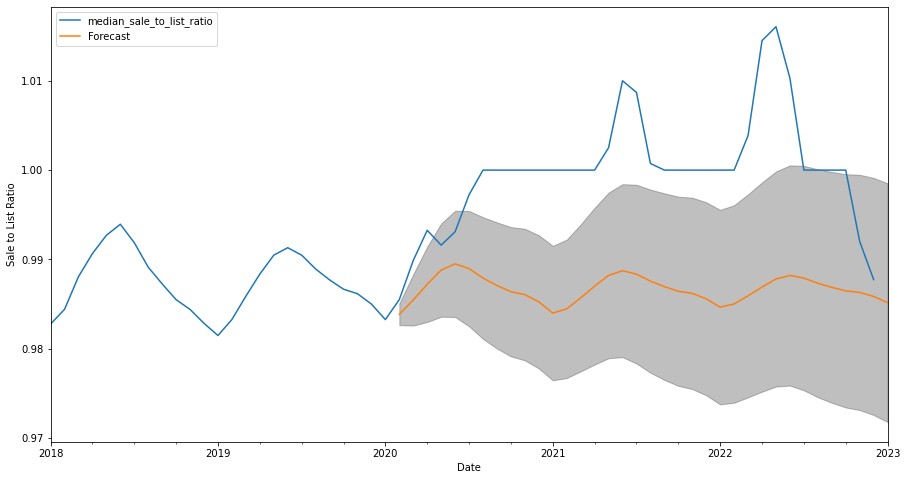

In [59]:
ax = us_ts[-2].plot(label='observed', figsize=(15, 8))

prediction.predicted_mean.plot(ax=ax, label='Forecast')

ax.fill_between(pred_conf.index,
                pred_conf.iloc[:, 0],
                pred_conf.iloc[:, 1], color='k', alpha=0.25)

ax.set_xlabel('Date')
ax.set_ylabel('Sale to List Ratio')

plt.legend()
plt.show()

In [60]:
prediction.predicted_mean.head()

2020-02-29    0.983860
2020-03-31    0.985470
2020-04-30    0.987213
2020-05-31    0.988808
2020-06-30    0.989503
Freq: M, Name: predicted_mean, dtype: float64

In [61]:
sale_to_list_res = us_ts[-2]
sale_to_list_preds = prediction.predicted_mean.to_frame()
sale_to_list_res = pd.concat([sale_to_list_res, sale_to_list_preds], axis=1).dropna()
sale_to_list_res['residuals'] = sale_to_list_res['median_sale_to_list_ratio'] - sale_to_list_res['predicted_mean']

In [62]:
sale_to_list_res.head()

median_sale_to_list_ratio  predicted_mean  residuals
2020-02-29                   0.985507        0.983860   0.001647
2020-03-31                   0.989888        0.985470   0.004418
2020-04-30                   0.993263        0.987213   0.006050
2020-05-31                   0.991597        0.988808   0.002789
2020-06-30                   0.993103        0.989503   0.003601

In [64]:
sp_truth['residuals'] = sp_truth['median_sale_price'] - sp_truth['forecast']
sp_truth.head()

median_sale_price       forecast     residuals
time                                                      
2020-01-31           247500.0  248085.374811   -585.374811
2020-02-29           250000.0  248582.909782   1417.090218
2020-03-31           259900.0  257364.014856   2535.985144
2020-04-30           260000.0  262937.089145  -2937.089145
2020-05-31           255500.0  268138.926888 -12638.926888

<AxesSubplot:xlabel='time'>

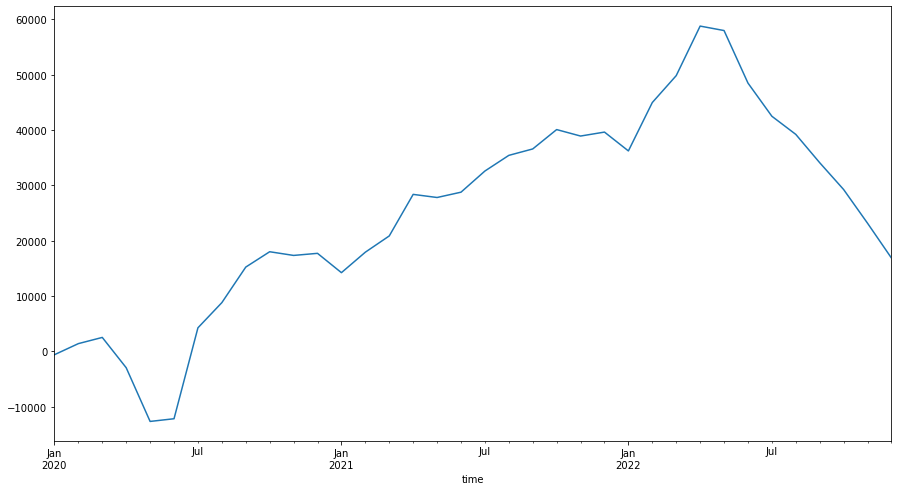

In [66]:
sp_truth['residuals'].plot()

<AxesSubplot:>

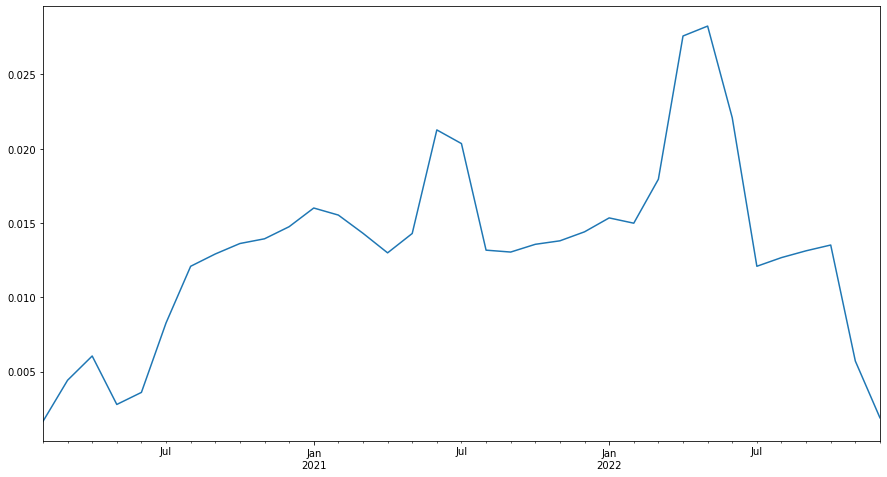

In [68]:
sale_to_list_res['residuals'].plot()

<AxesSubplot:xlabel='time'>

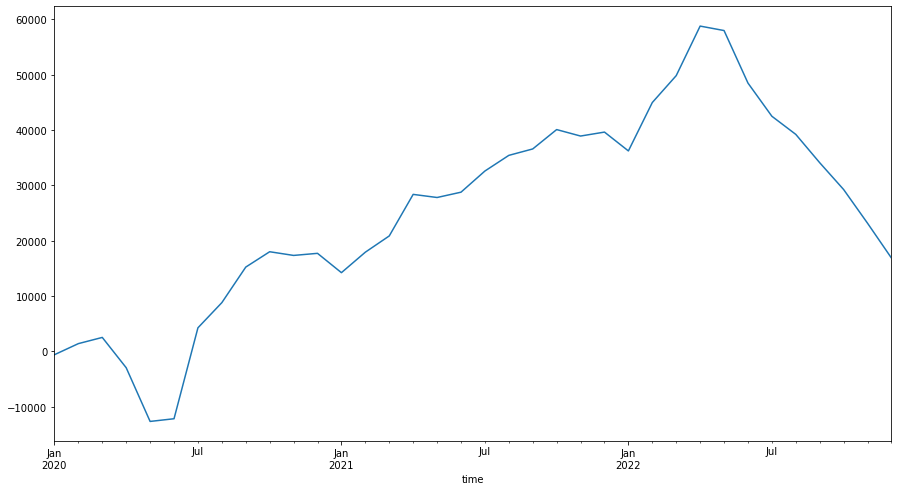

In [69]:
sp_truth['residuals'].plot()

In [77]:
sp_truth['stl_residuals_lin_adj'] = sp_truth['forecast'] * sale_to_list_res['residuals']
sp_truth['stl_residuals_exp_adj'] = sp_truth['forecast'] * ((sale_to_list_res['residuals']*100)**2/100)
sp_truth['forecast+stl_lin_adj'] = sp_truth['forecast'] + sp_truth['stl_residuals_lin_adj']
sp_truth['forecast+stl_exp_adj'] = sp_truth['forecast'] + sp_truth['stl_residuals_exp_adj']
sp_truth.head()

median_sale_price       forecast     residuals  \
time                                                         
2020-01-31           247500.0  248085.374811   -585.374811   
2020-02-29           250000.0  248582.909782   1417.090218   
2020-03-31           259900.0  257364.014856   2535.985144   
2020-04-30           260000.0  262937.089145  -2937.089145   
2020-05-31           255500.0  268138.926888 -12638.926888   

            stl_residuals_lin_adj  stl_residuals_exp_adj  \
time                                                       
2020-01-31                    NaN                    NaN   
2020-02-29             409.385350              67.420711   
2020-03-31            1136.975805             502.290106   
2020-04-30            1590.789098             962.439328   
2020-05-31             747.826059             208.564948   

            forecast+stl_lin_adj  forecast+stl_exp_adj  
time                                                    
2020-01-31                   NaN                   NaN  
2020-02-29         248992.295132         248650.330493  
2020-03-31         258500.990661         257866.304961  
2020-04-30         264527.878243         263899.528473  
2020-05-31         268886.752947         268347.491836

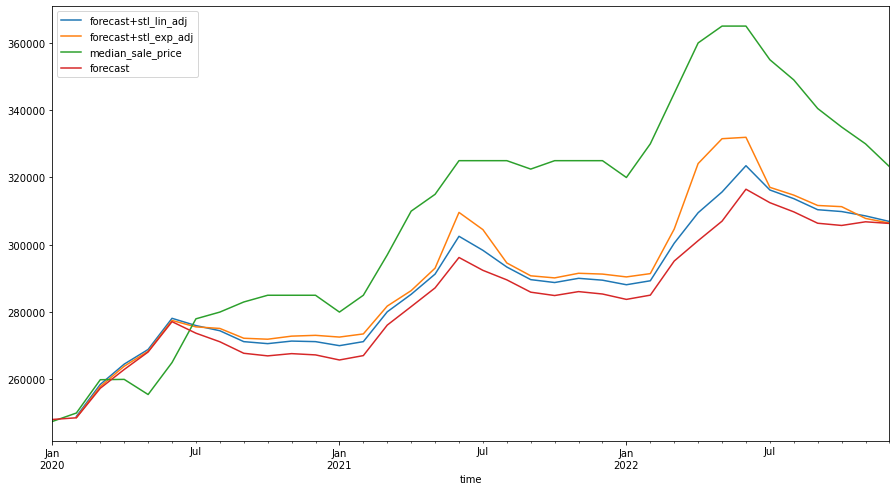

In [78]:
sp_truth['forecast+stl_lin_adj'].plot()
sp_truth['forecast+stl_exp_adj'].plot()
sp_truth['median_sale_price'].plot()
sp_truth['forecast'].plot()
plt.legend();

In [72]:
sp_truth['residuals'].corr(sale_to_list_res['residuals'])

0.7752686593117233

In [ ]:
interest_rate = pd.read_csv('raw_data/us_monthly_interest_rate.csv', index_col='DATE')
interest_rate.rename(columns={'FEDFUNDS':'int_rate'}, inplace=True)

us_int_rate = interest_rate['2008-02-01':]
us_int_rate['date'] = pd.date_range("2008-01-31", freq="M", periods=180)
us_int_rate.set_index('date', inplace=True)
us_int_rate

In [ ]:
us_int_rate.plot(figsize=(15,6));

## Jax example stuff

In [ ]:
idx = sale_price_loc.index('Jacksonville, FL')
roll_mean = sale_price_ts[idx].rolling(window=12, center=False).mean()
roll_std = sale_price_ts[idx].rolling(window=12, center=False).std()

In [ ]:
fig = plt.figure(figsize=(12,6))
plt.plot(sale_price_ts[idx], color='blue',label='Original')
plt.plot(roll_mean, color='red', label='Rolling Mean')
plt.plot(roll_std, color='black', label = 'Rolling Std')
plt.legend(loc='best')
plt.title('Rolling Mean & Standard Deviation: Jacksonville')
plt.show()

In [ ]:
dickey_fuller(sale_price_ts[idx])

## Try Again from scratch

In [ ]:
# find the index which allows us to split off 20% of the data
cutoff = round(sale_price_ts[idx].shape[0]*0.8)
cutoff

In [ ]:
# Define train and test sets according to the index found above
train = sale_price_ts[idx][:cutoff]

valid = sale_price_ts[idx][cutoff:]

fig, ax = plt.subplots(figsize=(12,8))
ax.plot(train, label='train')
# ax.plot(valid)
ax.plot(valid, label='valid')
ax.set_title('Train-Validation Split');
plt.legend()

In [ ]:
naive = train.shift(1)

fig, ax = plt.subplots()

train.plot(ax=ax, c='r', label='original')
naive.plot(ax=ax, c='b', label='shifted')
ax.set_title('naive')
ax.legend();

In [ ]:
naive_mrse = np.sqrt(mean_squared_error(train[1:], naive.dropna()))
naive_mrse

In [ ]:
fig, ax = plt.subplots()
residuals = naive[1:] - train[1:]
ax.plot(residuals.index, residuals)
ax.plot(residuals.index, residuals.rolling(30).std());

In [ ]:
fig, ax = plt.subplots()

ax.plot(residuals.index, residuals.rolling(30).var());

## Now that we have naive model for a baseline, we can build a SARIMA model

In [ ]:
fig, ax = plt.subplots(figsize=(16,3))
plot_acf(train, ax=ax, lags=40);

fig, ax = plt.subplots(figsize=(16,3))
plot_pacf(train, ax=ax, lags=40);

In [ ]:
# Define the p, d and q parameters to take any value between 0 and 2
p = d = q = range(0, 3)

# Generate all different combinations of p, q and q triplets
pdq = list(itertools.product(p, d, q))

# Generate all different combinations of seasonal p, q and q triplets
pdqs = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]

In [ ]:
# Run a grid with pdq and seasonal pdq parameters calculated above and get the best AIC value
ans = []
for comb in pdq:
    for combs in pdqs:
        try:
            mod = sm.tsa.statespace.SARIMAX(train,
                                            order=comb,
                                            seasonal_order=combs,
                                            enforce_stationarity=False,
                                            enforce_invertibility=False)

            output = mod.fit()
            ans.append([comb, combs, output.aic])
            print('ARIMA {} x {}: AIC Calculated={}'.format(comb, combs, output.aic))
        except:
            continue

In [ ]:
# Find the parameters with minimal AIC value
ans_df = pd.DataFrame(ans, columns=['pdq', 'pdqs', 'aic'])
ans_df.loc[ans_df['aic'].idxmin()]

In [ ]:
# Plug the optimal parameter values into a new SARIMAX model
ARIMA_MODEL = sm.tsa.statespace.SARIMAX(train, 
                                        order=(2,1,2), 
                                        seasonal_order=(0,2,2,12), 
                                        enforce_stationarity=False, 
                                        enforce_invertibility=False)

# Fit the model and print results
output = ARIMA_MODEL.fit()

print(output.summary())

In [ ]:
# Call plot_diagnostics() on the results calculated above 
output.plot_diagnostics(figsize=(15, 18))
plt.show()

In [ ]:
# Get predictions starting from 01-01-1998 and calculate confidence intervals
pred = output.get_prediction(start=pd.to_datetime('2017-01-31'), dynamic=False) #change start to validate dataset
pred_conf = pred.conf_int()

In [ ]:
pred_conf.index

In [ ]:
# Plot real vs predicted values along with confidence interval

rcParams['figure.figsize'] = 15, 6

# Plot observed values
ax = train.plot(label='observed')

# Plot predicted values
pred.predicted_mean.plot(ax=ax, label='One-step ahead Forecast', alpha=0.9)

# Plot the range for confidence intervals
ax.fill_between(pred_conf.index.values,
                pred_conf.iloc[:, 0],
                pred_conf.iloc[:, 1], color='g', alpha=0.5)

# Set axes labels
ax.set_xlabel('Date')
ax.set_ylabel('Median Sale Price')
plt.legend()

plt.show()

In [ ]:
# Get the real and predicted values
sp_forecasted = pred.predicted_mean
sp_truth = train['2017-01-31':]
sp_truth['forecast'] = sp_forecasted

# # Compute the mean square error
rmse = np.sqrt(((sp_truth['median_sale_price'] - sp_truth['forecast']) ** 2).mean())
print('Root Mean Squared Error of forecasts is {}'.format(round(rmse, 2)))

In [ ]:
# Get forecast 500 steps ahead in future
prediction = output.get_forecast(steps=36)

# Get confidence intervals of forecasts
pred_conf = prediction.conf_int()

In [ ]:
# Plot future predictions with confidence intervals
ax = sale_price_ts[idx].plot(label='observed', figsize=(20, 15))

prediction.predicted_mean.plot(ax=ax, label='Forecast')

ax.fill_between(pred_conf.index,
                pred_conf.iloc[:, 0],
                pred_conf.iloc[:, 1], color='k', alpha=0.25)

ax.set_xlabel('Date')
ax.set_ylabel('Median Sale Price')

plt.legend()
plt.show()

In [ ]:
# Run a grid with pdq and seasonal pdq parameters calculated above and get the best AIC value
ans = []
for comb in pdq:
    for combs in pdqs:
        try:
            mod = sm.tsa.statespace.SARIMAX(sale_price_ts[idx],
                                            order=comb,
                                            seasonal_order=combs,
                                            enforce_stationarity=False,
                                            enforce_invertibility=False)

            output = mod.fit()
            ans.append([comb, combs, output.aic])
            print('ARIMA {} x {}: AIC Calculated={}'.format(comb, combs, output.aic))
        except:
            continue

In [ ]:
ans_df = pd.DataFrame(ans, columns=['pdq', 'pdqs', 'aic'])
ans_df.loc[ans_df['aic'].idxmin()]

In [ ]:
# Plug the optimal parameter values into a new SARIMAX model
ARIMA_MODEL = sm.tsa.statespace.SARIMAX(sale_price_ts[idx], 
                                        order=(2,1,2), 
                                        seasonal_order=(2,2,2,12), 
                                        enforce_stationarity=False, 
                                        enforce_invertibility=False)

# Fit the model and print results
output = ARIMA_MODEL.fit()

print(output.summary())

In [ ]:
output.plot_diagnostics(figsize=(15, 18))
plt.show()

In [ ]:
pred = output.get_prediction(start=pd.to_datetime('2017-01-31'), dynamic=False) #change start to validate dataset
pred_conf = pred.conf_int()

In [ ]:
# Plot observed values
ax = sale_price_ts[idx].plot(label='observed')

# Plot predicted values
pred.predicted_mean.plot(ax=ax, label='One-step ahead Forecast', alpha=0.9)

# Plot the range for confidence intervals
ax.fill_between(pred_conf.index.values,
                pred_conf.iloc[:, 0],
                pred_conf.iloc[:, 1], color='g', alpha=0.5)

# Set axes labels
ax.set_xlabel('Date')
ax.set_ylabel('Median Sale Price')
plt.legend()

plt.show()

In [ ]:
sp_forecasted = pred.predicted_mean
sp_truth = train['2017-01-31':]
sp_truth['forecast'] = sp_forecasted

# # Compute the mean square error
rmse = np.sqrt(((sp_truth['median_sale_price'] - sp_truth['forecast']) ** 2).mean())
print('Root Mean Squared Error of forecasts is {}'.format(round(rmse, 2)))

In [ ]:
# Get forecast 500 steps ahead in future
prediction = output.get_forecast(steps=36)

# Get confidence intervals of forecasts
pred_conf = prediction.conf_int()

In [ ]:
ax = sale_price_ts[idx].plot(label='observed', figsize=(20, 15))

prediction.predicted_mean.plot(ax=ax, label='Forecast')

ax.fill_between(pred_conf.index,
                pred_conf.iloc[:, 0],
                pred_conf.iloc[:, 1], color='k', alpha=0.25)

ax.set_xlabel('Date')
ax.set_ylabel('Median Sale Price')

plt.legend()
plt.show()

In [81]:
big_df = pd.read_csv('zillow_data.csv')
big_df.head()

RegionID  RegionName      City State              Metro CountyName  \
0     84654       60657   Chicago    IL            Chicago       Cook   
1     90668       75070  McKinney    TX  Dallas-Fort Worth     Collin   
2     91982       77494      Katy    TX            Houston     Harris   
3     84616       60614   Chicago    IL            Chicago       Cook   
4     93144       79936   El Paso    TX            El Paso    El Paso   

   SizeRank   1996-04   1996-05   1996-06  ...  2017-07  2017-08  2017-09  \
0         1  334200.0  335400.0  336500.0  ...  1005500  1007500  1007800   
1         2  235700.0  236900.0  236700.0  ...   308000   310000   312500   
2         3  210400.0  212200.0  212200.0  ...   321000   320600   320200   
3         4  498100.0  500900.0  503100.0  ...  1289800  1287700  1287400   
4         5   77300.0   77300.0   77300.0  ...   119100   119400   120000   

   2017-10  2017-11  2017-12  2018-01  2018-02  2018-03  2018-04  
0  1009600  1013300  1018700  1024400  1030700  1033800  1030600  
1   314100   315000   316600   318100   319600   321100   321800  
2   320400   320800   321200   321200   323000   326900   329900  
3  1291500  1296600  1299000  1302700  1306400  1308500  1307000  
4   120300   120300   120300   120300   120500   121000   121500  

[5 rows x 272 columns]

In [105]:
jax_df = big_df[(big_df['City'] == 'Jacksonville') & (big_df['State'] == 'FL')]
jax_df

RegionID  RegionName          City State         Metro CountyName  \
102      71864       32210  Jacksonville    FL  Jacksonville      Duval   
206      71895       32244  Jacksonville    FL  Jacksonville      Duval   
229      71902       32256  Jacksonville    FL  Jacksonville      Duval   
243      71871       32218  Jacksonville    FL  Jacksonville      Duval   
301      71878       32225  Jacksonville    FL  Jacksonville      Duval   
401      71897       32246  Jacksonville    FL  Jacksonville      Duval   
970      71869       32216  Jacksonville    FL  Jacksonville      Duval   
1203     71877       32224  Jacksonville    FL  Jacksonville      Duval   
1300     71903       32257  Jacksonville    FL  Jacksonville      Duval   
1574     71861       32207  Jacksonville    FL  Jacksonville      Duval   
2347     71859       32205  Jacksonville    FL  Jacksonville      Duval   
2484     71904       32258  Jacksonville    FL  Jacksonville      Duval   
2596     71865       32211  Jacksonville    FL  Jacksonville      Duval   
2850     71910       32277  Jacksonville    FL  Jacksonville      Duval   
3972     71874       32221  Jacksonville    FL  Jacksonville      Duval   
4170     71876       32223  Jacksonville    FL  Jacksonville      Duval   
4945     71870       32217  Jacksonville    FL  Jacksonville      Duval   
5806     71879       32226  Jacksonville    FL  Jacksonville      Duval   
7700     71873       32220  Jacksonville    FL  Jacksonville      Duval   
7781     71872       32219  Jacksonville    FL  Jacksonville      Duval   
7804     71875       32222  Jacksonville    FL  Jacksonville      Duval   
8259     71858       32204  Jacksonville    FL  Jacksonville      Duval   
9615     71887       32234  Jacksonville    FL  Jacksonville      Duval   

      SizeRank   1996-04   1996-05   1996-06  ...  2017-07  2017-08  2017-09  \
102        103   63300.0   63200.0   63200.0  ...   116900   118900   121200   
206        207   78100.0   77700.0   77300.0  ...   139900   140900   142400   
229        230  176200.0  175200.0  174400.0  ...   320500   322700   324600   
243        244   73800.0   73700.0   73700.0  ...   154800   155500   156500   
301        302   92100.0   91700.0   91600.0  ...   222000   223400   225400   
401        402   79800.0   79800.0   79900.0  ...   180600   181800   182700   
970        971   73600.0   73300.0   73100.0  ...   150500   152200   154400   
1203      1204  129700.0  129000.0  128300.0  ...   298200   299000   300200   
1300      1301   95500.0   95100.0   94800.0  ...   204700   206500   208500   
1574      1575   69600.0   69500.0   69300.0  ...   150700   152300   153900   
2347      2348   54700.0   54600.0   54400.0  ...   132800   134800   136900   
2484      2485  111000.0  110800.0  110900.0  ...   237800   238400   239100   
2596      2597   62000.0   61700.0   61500.0  ...   125100   127600   130400   
2850      2851   83200.0   82800.0   82500.0  ...   159800   161100   162900   
3972      3973   87400.0   87300.0   87200.0  ...   160300   161500   163000   
4170      4171  126800.0  125600.0  124500.0  ...   252500   253700   254600   
4945      4946   88000.0   87700.0   87500.0  ...   193000   194400   195900   
5806      5807   93000.0   92000.0   91200.0  ...   220100   221000   222900   
7700      7701   79900.0   79700.0   79500.0  ...   156100   158900   161000   
7781      7782   75800.0   75000.0   74300.0  ...   137200   138300   139300   
7804      7805   94700.0   94700.0   94600.0  ...   177600   178400   179600   
8259      8260   41400.0   41400.0   41500.0  ...   161300   161600   163000   
9615      9616   68200.0   68400.0   68500.0  ...   161600   162800   163400   

      2017-10  2017-11  2017-12  2018-01  2018-02  2018-03  2018-04  
102    122900   124700   127100   129400   130100   130200   130400  
206    143500   144600   146100   147900   149600   151200   151800  
229    325500   327300   329200   330900   331400   331100   330100  
243 

In [107]:
zip_codes = jax_df['RegionName'].unique()
zip_codes

array([32210, 32244, 32256, 32218, 32225, 32246, 32216, 32224, 32257,
       32207, 32205, 32258, 32211, 32277, 32221, 32223, 32217, 32226,
       32220, 32219, 32222, 32204, 32234], dtype=int64)

In [102]:
jax_df.drop(['RegionID', 'SizeRank'], axis=1, inplace=True)

In [103]:
def melt_data(df):
    melted = pd.melt(df, id_vars=['RegionID', 'RegionName', 'City', 'State', 'Metro', 'CountyName', 'SizeRank'], var_name='time')
    melted['time'] = pd.to_datetime(melted['time'], infer_datetime_format=True)
    melted = melted.dropna(subset=['value'])
    return melted.groupby('time').aggregate({'value':'mean'})

In [104]:
for zip_code in zip_codes:
    

value
time                     
1996-04-01   86860.869565
1996-05-01   86517.391304
1996-06-01   86247.826087
1996-07-01   86034.782609
1996-08-01   85926.086957
...                   ...
2017-12-01  190360.869565
2018-01-01  192226.086957
2018-02-01  193495.652174
2018-03-01  194434.782609
2018-04-01  194869.565217

[265 rows x 1 columns]